## Final Project Submission


* Student name:  Noah-John Hizon
* Student pace: part time 
* Scheduled project review date/time: 5/11 2:30 PM
* Instructor name: Abhineet Kulkarni
* Blog post URL: 

# Predicting the Outcomes of NBA Games

## Overview

The focus of this project is to provide insight for NBA analysts towards understanding the most critical aspects that contribute to an NBA game's resulting final score. This project will be able to accurately predict how an NBA game will turn out given a set list of team attributes. Data regarding NBA games played in the 2019-2022 span (3 seasons) will be utilized to compose a final classifier model. The results of this modeling process will change the perspective on how analysts look at resulting game outcomes, and the factors that most affect them. 

## Business Problem 


The National Basketball Association (NBA) has changed to a great degree, especially in the past 3 years. While this is in large part due to the effects of the COVID-19 pandemic, the player base that has grown to prominence undoubtedly has the greatest effect. Players like Nikola Jokic, Stephen Curry, Kevin Durant, and Lebron James have changed the game to a great degree. With each passing year in the NBA, they set a new standard for future generations to live up to/surpass. The quality of an NBA player/team is not only defined by how well they shoot the ball or block shots; there is a myriad of other atrributes that emphasize overall contribution. Even from a holistic perspective, new coaches bring in new strategies into the mix that prioritize around certain players, methods of scoring, or managing game pace. 

In an ever-fluctuating game state, analysts may be flustered when events occur that discount their game predictions or takes. While mid-game injuries, mid-season trades, and coaching changes are unavoidable factors that can throw off predictions, certain game stats should be scrutinized; when interpreted incorrectly, mistakes can prove to be costly. Lack of validity cost analysts their overall credibility, which may lead to ridicule or job loss, in extreme cases. 

Data from the NBA 2019-2022 seasons (3 total seasons) will be aggregated/summarized in order to determine the most impactful characteristics that contribute to NBA game wins, and develop a machine learning model that can accurately predict the outcome of any game. Understanding the effect of every possible contributing game stat/contributor would help analysts make more informed predictions. The output of this project would help build an analyst's reputation while also  educating the fanbase on the numbers that truly matter. 

## Data Understanding

As seen below, the imported NBA data contains a variety of information related to the defining metrics for each game played in the 3 individual seasons (2019-2020, 2020-2021, 2021-2022). The data was originally exported on the player level of granularity, but was aggregated/cleaned via Excel, in order to have each row represented as an individual game. Players were aggregated and included in the overall dataset if their minutes played value was not equal to 0. 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, train_test_split, cross_validate, cross_val_score, ShuffleSplit, KFold
import statsmodels.api as sm
from sklearn.feature_selection import RFECV, RFE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, make_scorer
import statsmodels.formula.api as smf
import scipy.stats as stats
import statsmodels.stats.api as sms
from itertools import combinations
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

nbadata = pd.read_csv('20192022NBAGAMES3.csv',header=0)

In [2]:
bothteams=nbadata[['CLEANED NAME','GAME RESULT','POINT DIFFERENCE','PACE']]
bothteams.head()

,CLEANED NAME,GAME RESULT,POINT DIFFERENCE,PACE
0,20191022-H-LAC-A-LAL,1,10,95.3
1,20191022-H-TOR-A-NOP,1,8,102.2
2,20191023-H-BRK-A-MIN,0,1,105.2
3,20191023-H-CHO-A-CHI,1,1,101.6
4,20191023-H-DAL-A-WAS,1,8,103.7


The data is comprised of 32 individual fields. 
There are 4 columns which represent cumulative game metrics across both teams,  __CLEANED NAME, GAME RESULTS, POINT DIFFERENCE, and PACE.__ 

The __CLEANED NAME__ is the unique identifier across the data set. Within the nomenclature, the field contains the date the game was played, the name of the home team, and the name of the away team.  This field will not be relevant for the model build, but it will be useful in the future steps of the analysis to understand which teams won which game. 

The __GAME RESULT__ field will be the classifier that the model will eventually try to predict. This is a binary outcome classifier, represented as 1if the home team wins, and 0 if the away team wins. 

The __POINT DIFFERENCE__ is derived from taking the absolute value of the difference between the Home and Away team's final scores.  For example, if the Home team scored 130 points, and the Away team scored 110 points, the point difference value would be 20. That being said, since the absolute value was taken within the calculation, every value in this column is an integer greater than zero.

The __PACE__ of the game is represented by how many individual possessions take place across both teams. It is a metric that defines the speed at which the game is played, And is calculated by the formula below:

PACE= 48 * ((Home team Possessions + Away team Possessions) / (2 * (Minutes played / 5)))

48 is an arbitrary number, used to represent the total minutes in a standard 4 quarter NBA game. 

In [3]:
nbadata.columns

Index(['CLEANED NAME', 'GAME RESULT', 'POINT DIFFERENCE', 'PACE',
       'HOME TEAM OFFENSIVE RATING', 'HOME TEAM DEFENSIVE RATING',
       'HOME TEAM 2PT%', 'HOME TEAM 3PT%', 'HOME TEAM FT%',
       'HOME TEAM REBOUNDS', 'HOME TEAM ASSISTS', 'HOME TEAM STEALS',
       'HOME TEAM BLOCKS', 'HOME TEAM TURNOVERS',
       'HOME TEAM AVERAGE PLUS/MINUS', 'HOME TEAM DOUBLE DOUBLES',
       'HOME TEAM TOP 50 CONTRACT PLAYERS', 'AWAY TEAM OFFENSIVE RATING',
       'AWAY TEAM DEFENSIVE RATING', 'AWAY TEAM 2PT%', 'AWAY TEAM 3PT%',
       'AWAY TEAM FT%', 'AWAY TEAM REBOUNDS', 'AWAY TEAM ASSISTS',
       'AWAY TEAM STEALS', 'AWAY TEAM BLOCKS', 'AWAY TEAM TURNOVERS',
       'AWAY TEAM AVERAGE PLUS/MINUS', 'AWAY TEAM DOUBLE DOUBLES',
       'AWAY TEAM TOP 50 CONTRACT PLAYERS'],
      dtype='object')

The other 28 columns are split amongst the home and away teams,  resulting in 14 fields represented for each team.

__OFFENSIVE RATING__ represents each team’s performance as a result of the following formula: 
Offensive Team Rating = (Points*Total FG%) + Point Difference= 1/5 of possessions - Times Fouled+ FTM* FT% * OAPOW (Official Adjusted Players Offensive Withstand).
 
__DEFENSIVE RATING__ was represented in the initial data set on a player by player basis. The metric was averaged for any player that had minutes logged in the game, to get a cumulative team rating. The  column was calculated by the following formula for each player:
Defensive Player Rating = (Players Steals*Blocks) + Opponents Differential= 1/5 of possessions - Times blown by + Deflections * OAPDW( Official Adjusted Players Defensive Withstand

The respective field goal percentages, __2PT%__, __3PT%__, __FT%__  are represented by  the amount of made team field goals/field goal attempts for each shot type (2 point - shot within the 3 point line, 3 point - shot outside the 3 point line, free throw - at the line, after a shooting foul has occurred). 

__OFFENSIVE REBOUNDS__ represent rebounds made by the scoring team, keeping possession of the ball, while __DEFENSIVE REBOUNDS__ represent those where the defending team takes possession after a scoring team's shot attempt.

An __ASSIST__ represents the event where a player passes the ball to a teammate in a way that directly leads to a field goal score.

A __BLOCK__ represents the event where a defending player legally deflects a field goal attempt by the scoring player.

A __STEAL__ represents the event where a defensive player legally makes a turnover, causing a change in possession. 

A __TURNOVER__ represents a change in possession that occurs before a player on the offensive team attempts a shot.

__PLUS/MINUS__ is an aggregated metric, averaged amongst the players in the original dataset with played minutes. This metric reflects how the team did while an individual player is on the court. For example, if a player has a +5, it means the team outscored the opposing team by 5 points while they were on the court.

A __DOUBLE-DOUBLE__ represents the event where an individual player reaches double figures (10 or more) in 2 of the 5 main stat categories (points, rebounds, assists, steals, and blocks). A running count is aggregated for each home/away team. 

The final metric, __TOP 50 CONTRACT PLAYERS__, is a derived metric based on ESPN’s player salary database. A list of the players with the top 50 salary contracts was compiled for the 3 seasons, then a distinct list was found through deduplication. When aggregating the games by player, a running count was summed for each home/away team. 

In [4]:
nbadata.describe()

,GAME RESULT,POINT DIFFERENCE,PACE,HOME TEAM OFFENSIVE RATING,HOME TEAM DEFENSIVE RATING,HOME TEAM 2PT%,HOME TEAM 3PT%,HOME TEAM FT%,HOME TEAM REBOUNDS,HOME TEAM ASSISTS,...,AWAY TEAM 3PT%,AWAY TEAM FT%,AWAY TEAM REBOUNDS,AWAY TEAM ASSISTS,AWAY TEAM STEALS,AWAY TEAM BLOCKS,AWAY TEAM TURNOVERS,AWAY TEAM AVERAGE PLUS/MINUS,AWAY TEAM DOUBLE DOUBLES,AWAY TEAM TOP 50 CONTRACT PLAYERS
count,3544.000000,3544.000000,3544.000000,3544.000000,3544.000000,3544.000000,3544.000000,3544.000000,3544.000000,3544.000000,...,3544.000000,3544.000000,3544.000000,3544.000000,3544.000000,3544.000000,3544.000000,3544.000000,3544.000000,3544.000000
mean,0.545711,12.014391,98.438347,113.357619,111.954818,0.534781,0.361192,0.775971,44.935666,24.889108,...,0.356022,0.775430,44.004797,24.134594,7.648138,4.694977,13.327596,-0.786845,0.865971,1.538093
std,0.497976,8.931961,4.889579,11.684333,11.731960,0.073262,0.084352,0.100937,6.591147,4.976020,...,0.084368,0.103719,6.478147,4.936538,2.899202,2.380848,3.824939,6.658701,0.757936,1.139303
min,0.000000,1.000000,82.200000,76.900000,65.777778,0.225806,0.088889,0.307692,24.000000,10.000000,...,0.076923,0.315789,25.000000,8.000000,0.000000,0.000000,2.000000,-41.666667,0.000000,0.000000
25%,0.000000,5.000000,95.100000,105.200000,104.305769,0.486753,0.305556,0.713346,40.000000,21.000000,...,0.300000,0.714286,39.000000,21.000000,6.000000,3.000000,11.000000,-5.416667,0.000000,1.000000
50%,1.000000,10.000000,98.300000,113.300000,112.133929,0.534483,0.360000,0.782609,45.000000,25.000000,...,0.354167,0.781250,44.000000,24.000000,7.000000,4.000000,13.000000,-1.363636,1.000000,1.000000
75%,1.000000,16.000000,101.600000,121.400000,119.600000,0.584906,0.418605,0.846154,49.000000,28.000000,...,0.411765,0.846154,48.000000,27.000000,10.000000,6.000000,16.000000,4.090909,1.000000,2.000000
max,1.000000,73.000000,118.200000,159.300000,155.909091,0.782609,0.684211,1.000000,70.000000,50.000000,...,0.680000,1.000000,66.000000,41.000000,19.000000,15.000000,30.000000,25.909091,4.000000,5.000000


In [5]:
nbadata=nbadata.drop(['CLEANED NAME'],axis=1)
nbadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3544 entries, 0 to 3543
Data columns (total 29 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   GAME RESULT                        3544 non-null   int64  
 1   POINT DIFFERENCE                   3544 non-null   int64  
 2   PACE                               3544 non-null   float64
 3   HOME TEAM OFFENSIVE RATING         3544 non-null   float64
 4   HOME TEAM DEFENSIVE RATING         3544 non-null   float64
 5   HOME TEAM 2PT%                     3544 non-null   float64
 6   HOME TEAM 3PT%                     3544 non-null   float64
 7   HOME TEAM FT%                      3544 non-null   float64
 8   HOME TEAM REBOUNDS                 3544 non-null   int64  
 9   HOME TEAM ASSISTS                  3544 non-null   int64  
 10  HOME TEAM STEALS                   3544 non-null   int64  
 11  HOME TEAM BLOCKS                   3544 non-null   int64

After removing the name identifier as our only categorical variable, the data is preprocessed and is ready to be modeled. 


## Data Preparation


Due to all relevant fields already being in numerical form, no additional preprocessing is necessary before the modeling process is started. The initial, unprocessed dataset already had all of the information in numerical form to begin with, the aggregation was done in Excel to avoid redundancy/keep simplicity. If the data were to be preprocessed in Python, the groupby function would be used to summarize each numerical column, either summing or averaging relevant data certain columns, then grouping by the __CLEANED NAME__ field as an identifier, while dropping the player name field. Players that had a __MINUTES PLAYED__ value were the only ones aggregated in the overall metrics. Players listed in a game with no minutes played would inherently be dropped, as their inclusion would throw off the average metrics.  

In [6]:
nbadata.dtypes

GAME RESULT                            int64
POINT DIFFERENCE                       int64
PACE                                 float64
HOME TEAM OFFENSIVE RATING           float64
HOME TEAM DEFENSIVE RATING           float64
HOME TEAM 2PT%                       float64
HOME TEAM 3PT%                       float64
HOME TEAM FT%                        float64
HOME TEAM REBOUNDS                     int64
HOME TEAM ASSISTS                      int64
HOME TEAM STEALS                       int64
HOME TEAM BLOCKS                       int64
HOME TEAM TURNOVERS                    int64
HOME TEAM AVERAGE PLUS/MINUS         float64
HOME TEAM DOUBLE DOUBLES               int64
HOME TEAM TOP 50 CONTRACT PLAYERS      int64
AWAY TEAM OFFENSIVE RATING           float64
AWAY TEAM DEFENSIVE RATING           float64
AWAY TEAM 2PT%                       float64
AWAY TEAM 3PT%                       float64
AWAY TEAM FT%                        float64
AWAY TEAM REBOUNDS                     int64
AWAY TEAM 

The data is now prepped for modeling. For this project, the plan is to use a classification model in order to assign a classifier to any given game, each game represented by a row in the dataset. The classification model will predict a binary outcome variable, represented by 0 or 1. 1 represents a win by the home team, and 0 represents a win by the away team.

C:\Users\noahi\anaconda3\envs\learn-env\lib\site-packages\pandas\plotting\_matplotlib\tools.py:185: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)


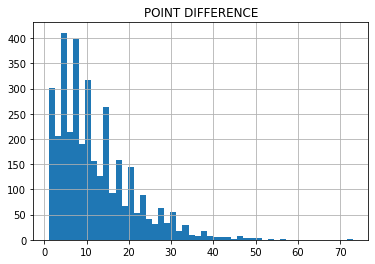

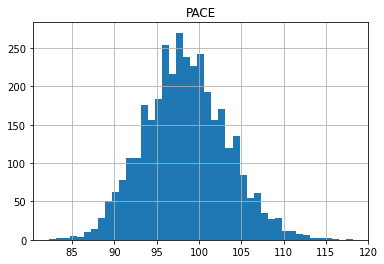

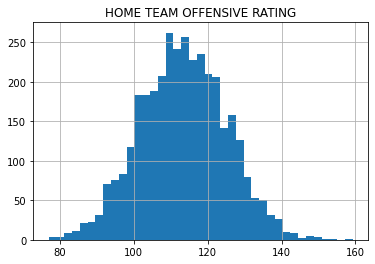

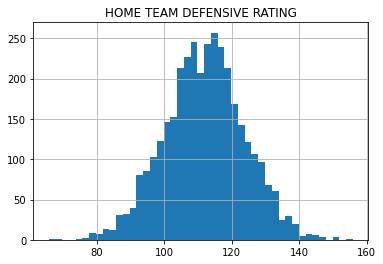

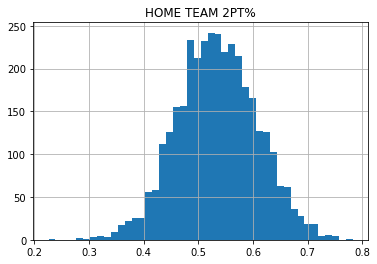

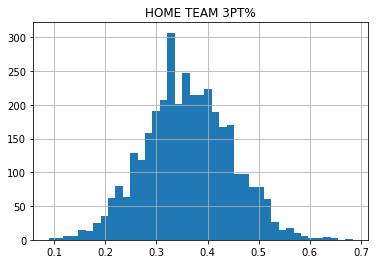

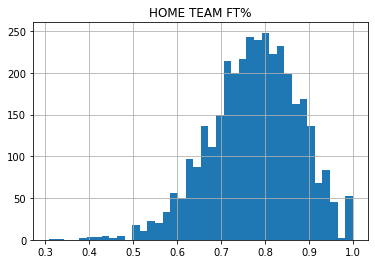

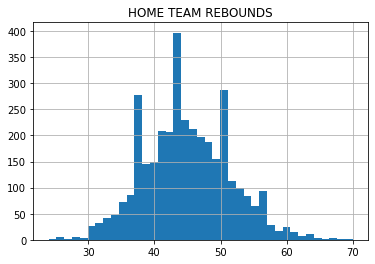

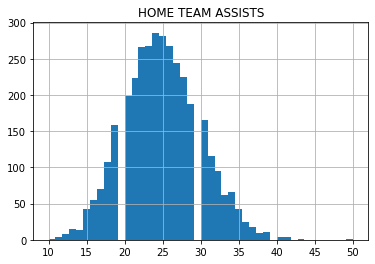

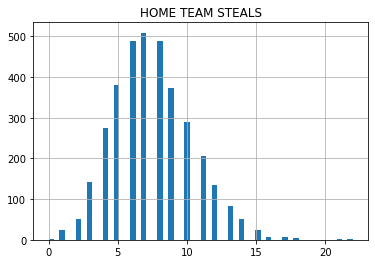

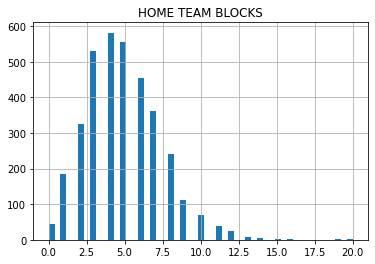

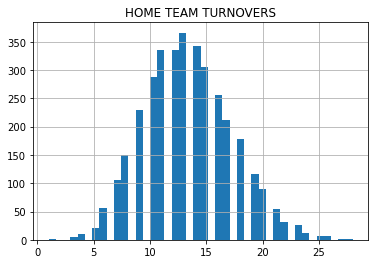

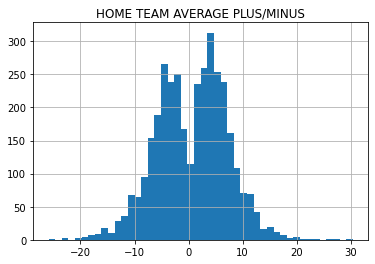

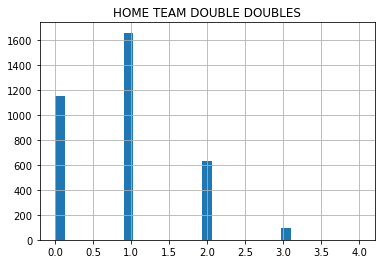

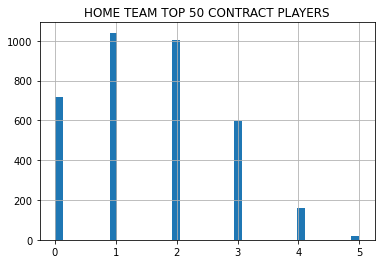

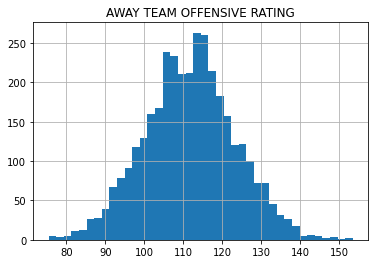

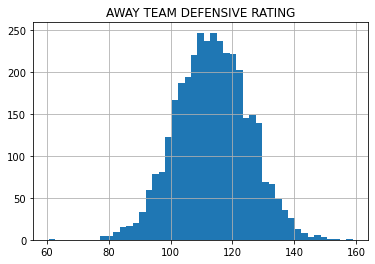

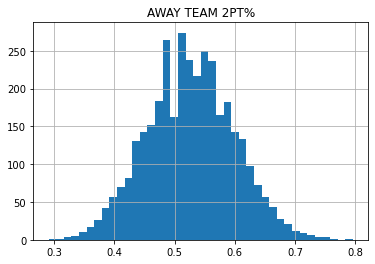

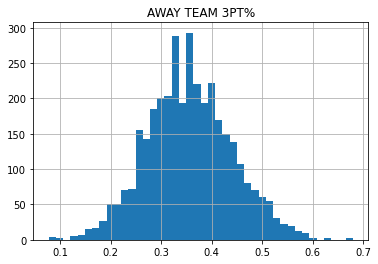

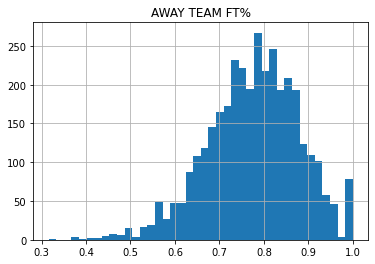

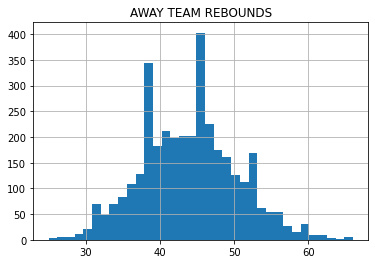

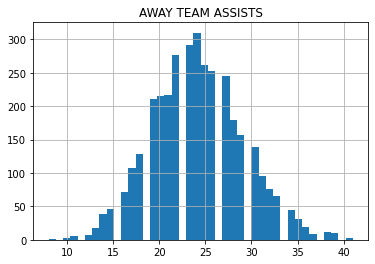

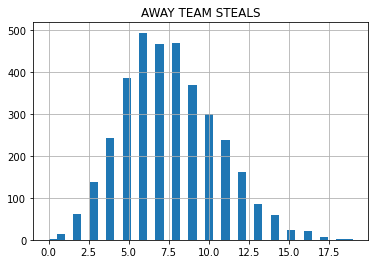

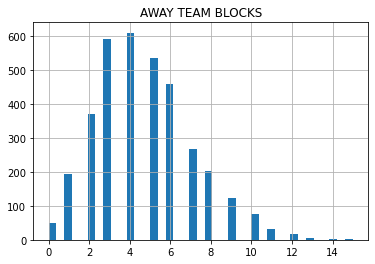

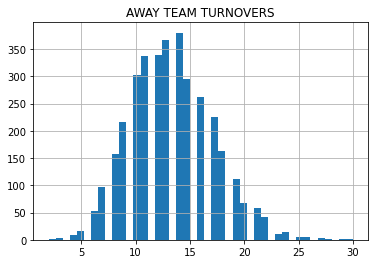

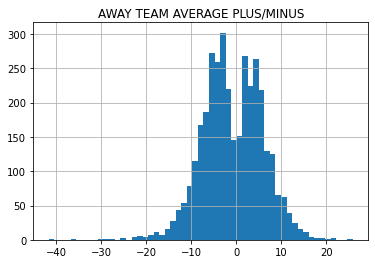

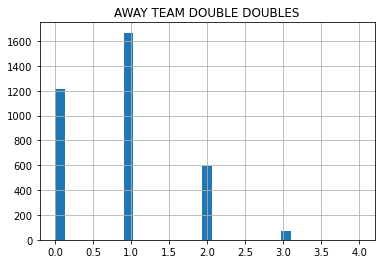

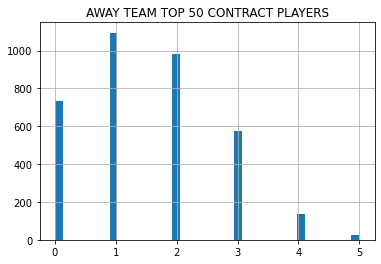

In [7]:
for col in ['POINT DIFFERENCE', 'PACE',
       'HOME TEAM OFFENSIVE RATING', 'HOME TEAM DEFENSIVE RATING',
       'HOME TEAM 2PT%', 'HOME TEAM 3PT%', 'HOME TEAM FT%', 'HOME TEAM REBOUNDS',
       'HOME TEAM ASSISTS', 'HOME TEAM STEALS', 'HOME TEAM BLOCKS',
       'HOME TEAM TURNOVERS', 'HOME TEAM AVERAGE PLUS/MINUS',
       'HOME TEAM DOUBLE DOUBLES', 'HOME TEAM TOP 50 CONTRACT PLAYERS',
       'AWAY TEAM OFFENSIVE RATING', 'AWAY TEAM DEFENSIVE RATING',
       'AWAY TEAM 2PT%', 'AWAY TEAM 3PT%', 'AWAY TEAM FT%', 'AWAY TEAM REBOUNDS',
       'AWAY TEAM ASSISTS', 'AWAY TEAM STEALS', 'AWAY TEAM BLOCKS',
       'AWAY TEAM TURNOVERS', 'AWAY TEAM AVERAGE PLUS/MINUS',
       'AWAY TEAM DOUBLE DOUBLES', 'AWAY TEAM TOP 50 CONTRACT PLAYERS']:
    nbadata.hist(column=col, bins='auto')

Upon first glance, the majority of the variables already seem normally distributed when plotted in histograms. This is promising as it means that there might not be a need to do extensive data manipulation in order to satisfy the assumptions of normality.

However, it should be noted that the scale of the variables is drastically different, with some being represented as solely positive integers, while some variables like average __PLUS/MINUS__ may also contain negative values. That being said, a scaler will have to be applied in order to improve validity and performance of our model. 


## Data Modeling

Now that the relevant columns are cleaned, modeling with a focus on 'GAME RESULT' as the target outcome variable can begin. A machine learning model is desired for this analysis, due to the necessity of a system that can predict wins given a set number of fields. The model's win predictions will be compared to the actual win results from the 2019-2022 seasons; an accurate model will reveal what the most impactful columns were on win rate. 


First, a heat map is created to show the correlation between all of our variables.

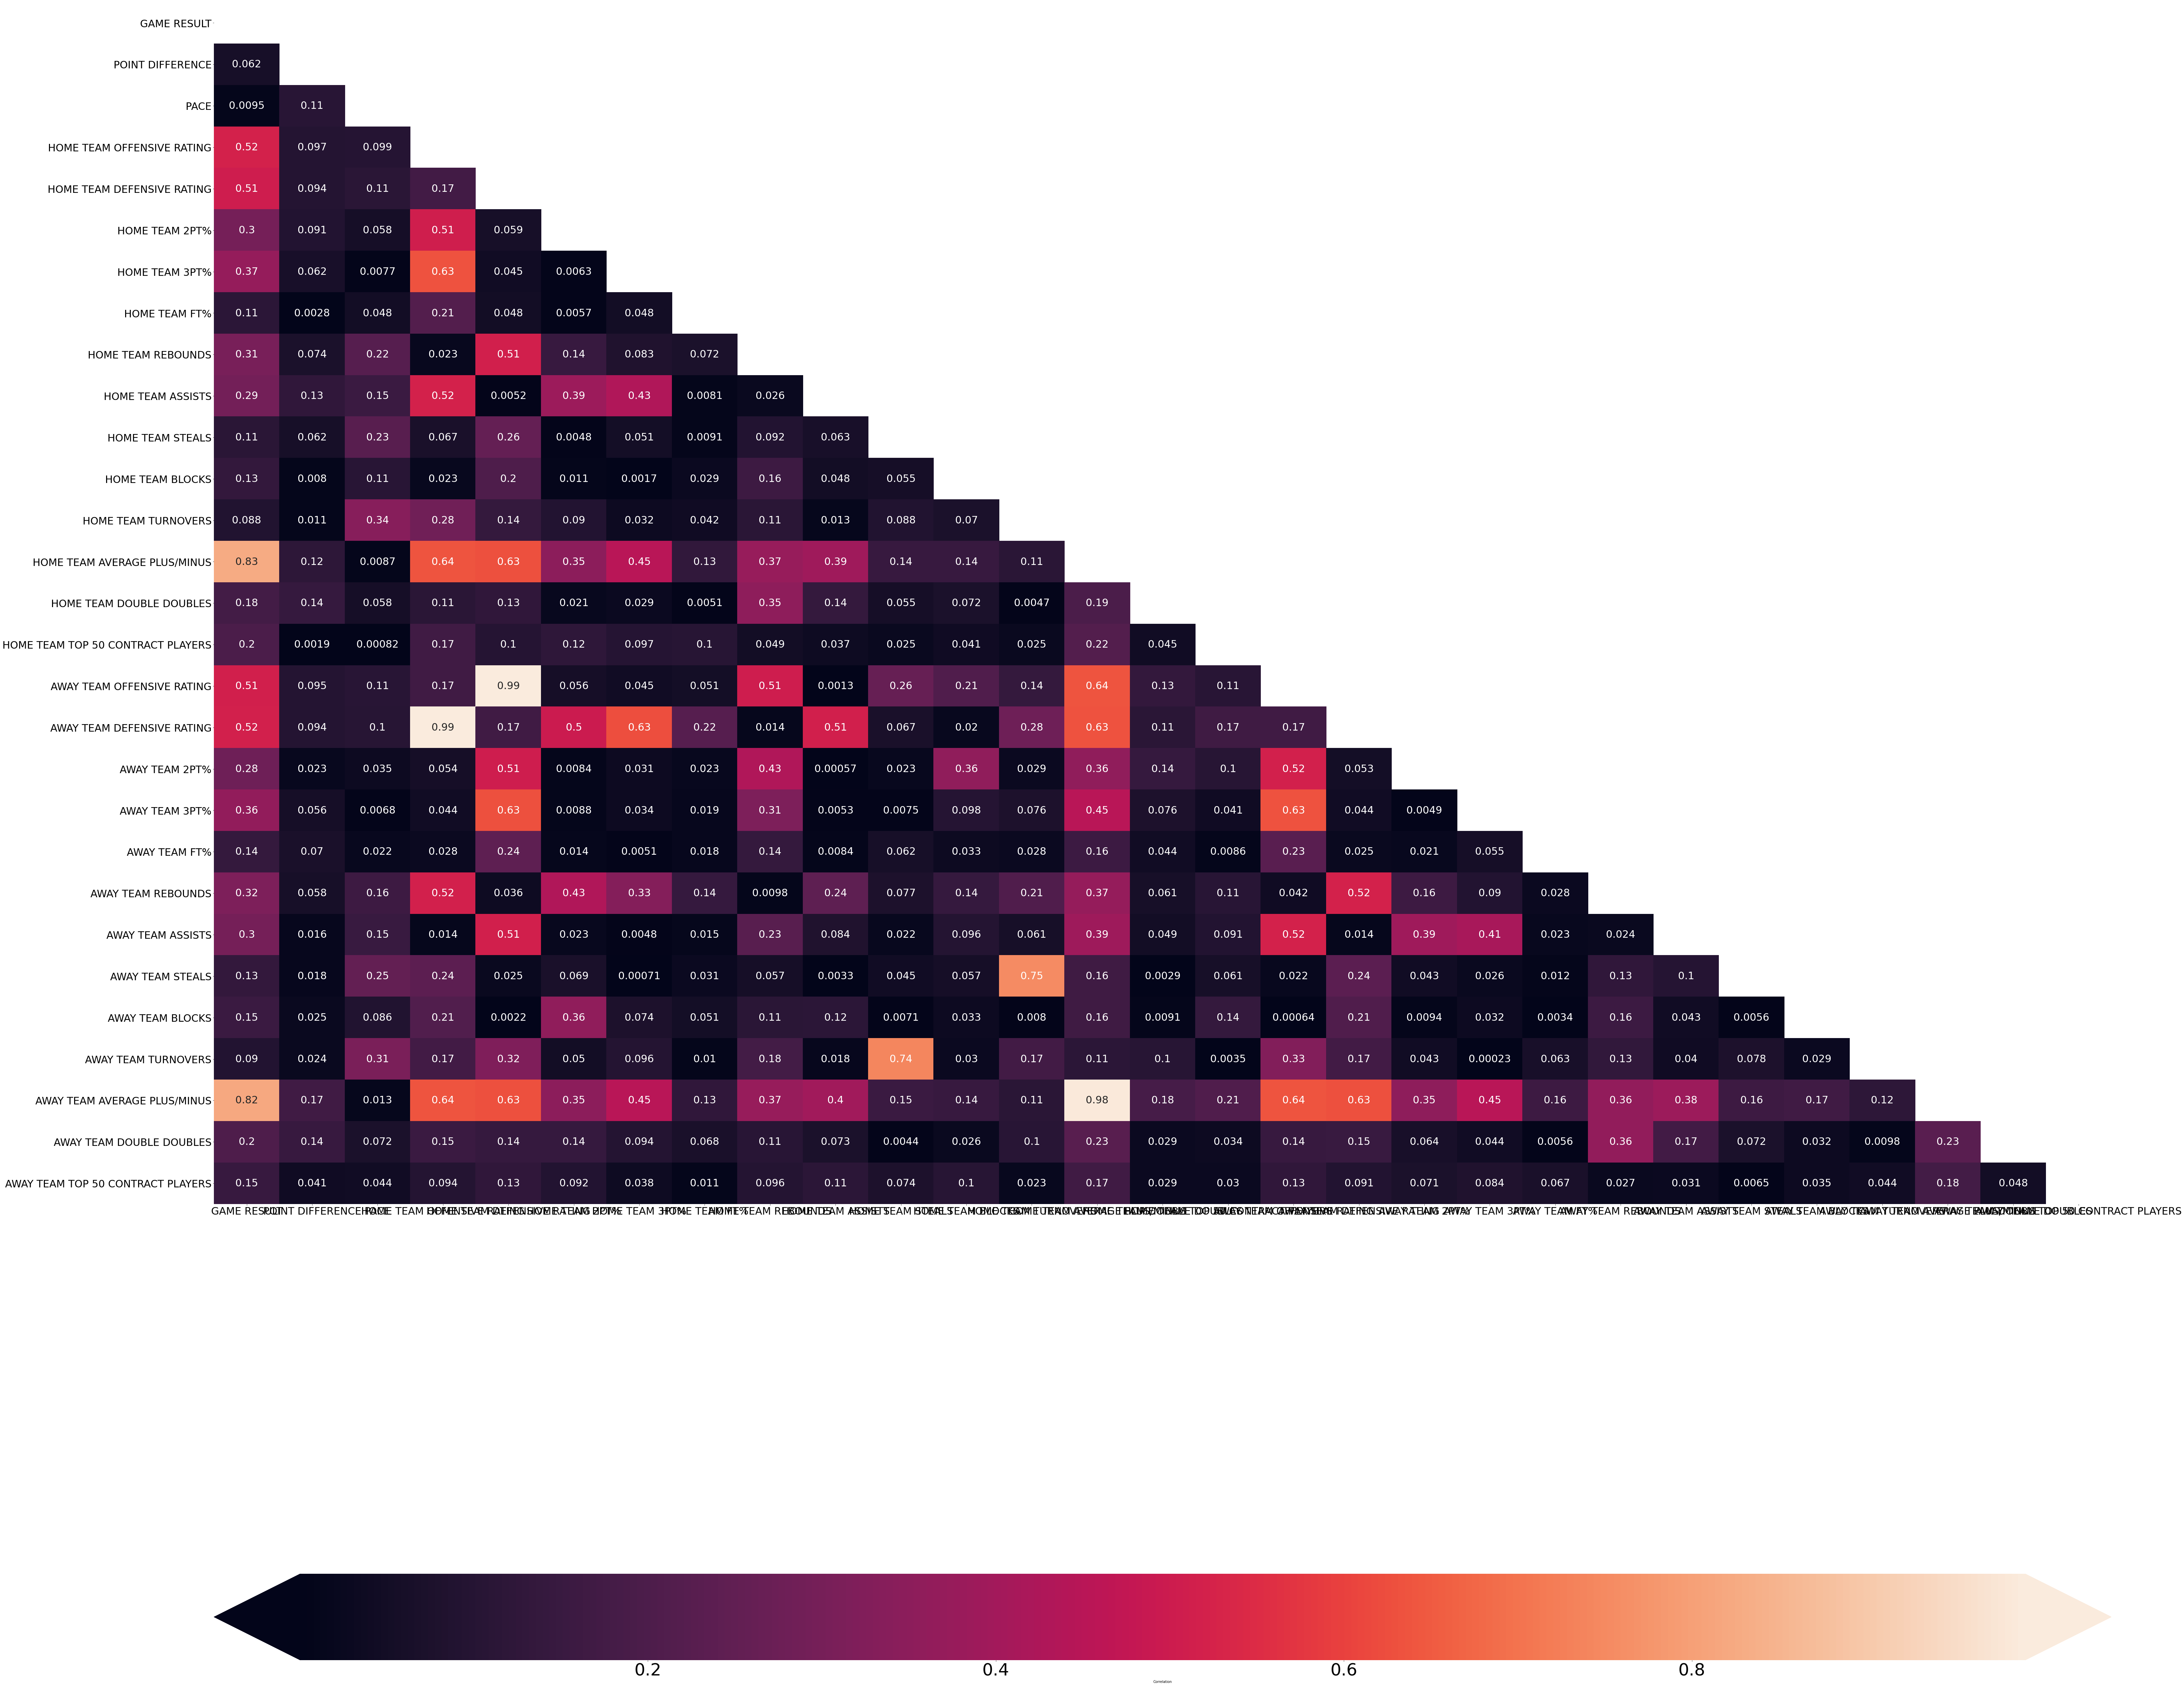

In [8]:
correlation=abs(nbadata.corr())

fig, ax = plt.subplots(figsize=(100, 100))
heat=sns.heatmap(annot_kws={"fontsize":30},
    data=correlation,
    mask=np.triu(np.ones_like(correlation, dtype=bool)),
    ax=ax,
    annot=True,
    cbar_kws={"label": "Correlation", "orientation": "horizontal", "pad": .2, "extend": "both"}
)
ax.collections[0].colorbar.ax.tick_params(labelsize=50)
heat.set_xticklabels(heat.get_xmajorticklabels(), fontsize = 30)
heat.set_yticklabels(heat.get_ymajorticklabels(), fontsize = 30)
plt.show()

For the most part, it seems that most of our variables have little correlation with each other, seen by the abundance of  combination correlations being below .4. There are some variable pairs that stand out as being highly correlated with each other. 
Due to the abundance of variables, the standout correlated pairs are difficult to pinpoint. The following code displays the top correlated variables within our dataset.

In [9]:
df=abs(nbadata.corr()>.75)
df=correlation.abs().stack().reset_index().sort_values(0,ascending=False)
df['paired']=list(zip(df.level_0,df.level_1))
df.set_index(['paired'],inplace=True)
df.drop(columns=['level_1','level_0'],inplace=True)
df.drop_duplicates(inplace=True)
df.head(20)

,0
paired,
"(GAME RESULT, GAME RESULT)",1.000000
"(HOME TEAM DEFENSIVE RATING, AWAY TEAM OFFENSIVE RATING)",0.991417
"(HOME TEAM OFFENSIVE RATING, AWAY TEAM DEFENSIVE RATING)",0.988798
"(AWAY TEAM AVERAGE PLUS/MINUS, HOME TEAM AVERAGE PLUS/MINUS)",0.984488
"(GAME RESULT, HOME TEAM AVERAGE PLUS/MINUS)",0.825814
"(GAME RESULT, AWAY TEAM AVERAGE PLUS/MINUS)",0.818169
"(HOME TEAM TURNOVERS, AWAY TEAM STEALS)",0.752596
"(AWAY TEAM TURNOVERS, HOME TEAM STEALS)",0.743437
"(HOME TEAM OFFENSIVE RATING, HOME TEAM AVERAGE PLUS/MINUS)",0.638910


In order to avoid the issue of multicollinearity, aome of the attributes as defined above will need to be removed from the model. Multicollinearity is inherently a problem as performing a predictive model assumes that unit changes in each individual column has no effect on the others. That being said, a variable from each pairing with a correlation Factor greater than .75 will be removed from the model to mitigate this issue. 
 
Since __OFFENSIVE RATING__ and __DEFENSIVE RATING__ are scored on a game by game basis, it is natural that a game with a high calculated Home team offensive rating would consequently have a low Away team defensive rating. The outcome variable is based on point metrics,__OFFENSIVE/DEFENSIVE RATINGS__ will be removed for model validity.

Since __PLUS/MINUS__ is an attribute calculated based on when either a home or away team player is on the floor,  home and away team metrics will inherently have an inverse relationship.  The more points an Away team member scores than a Home team member, the higher the away team's overall plus/minus would be and the lower the home team's overall plus/minus will be.  Upon combing through the data, since the plus/minus metric is directly based on aggregate points scored, the comparison of home/away team plus/minus is associated with points scored by each team. The outcome variable is based on point metrics, we will remove the __PLUS/MINUS RATINGS__ for model validity.

Similarly, __TURNOVERS__ and __STEALS__ are correlated, as a steal from a Home team player inherently counts as a legal turnover counted for the Away team. 

__POINT DIFFERENCE__ was removed, as that metric is directly based on points, which is directly correlated to a win designation. 

Below, the highly correlated variables in the dataset are dropped. 

In [10]:
nbadata=nbadata.drop(['AWAY TEAM OFFENSIVE RATING','AWAY TEAM DEFENSIVE RATING',
                      'AWAY TEAM AVERAGE PLUS/MINUS','AWAY TEAM STEALS',
                      'AWAY TEAM TURNOVERS','HOME TEAM AVERAGE PLUS/MINUS',
                      'HOME TEAM OFFENSIVE RATING','HOME TEAM DEFENSIVE RATING', 
                     'POINT DIFFERENCE'],axis=1)

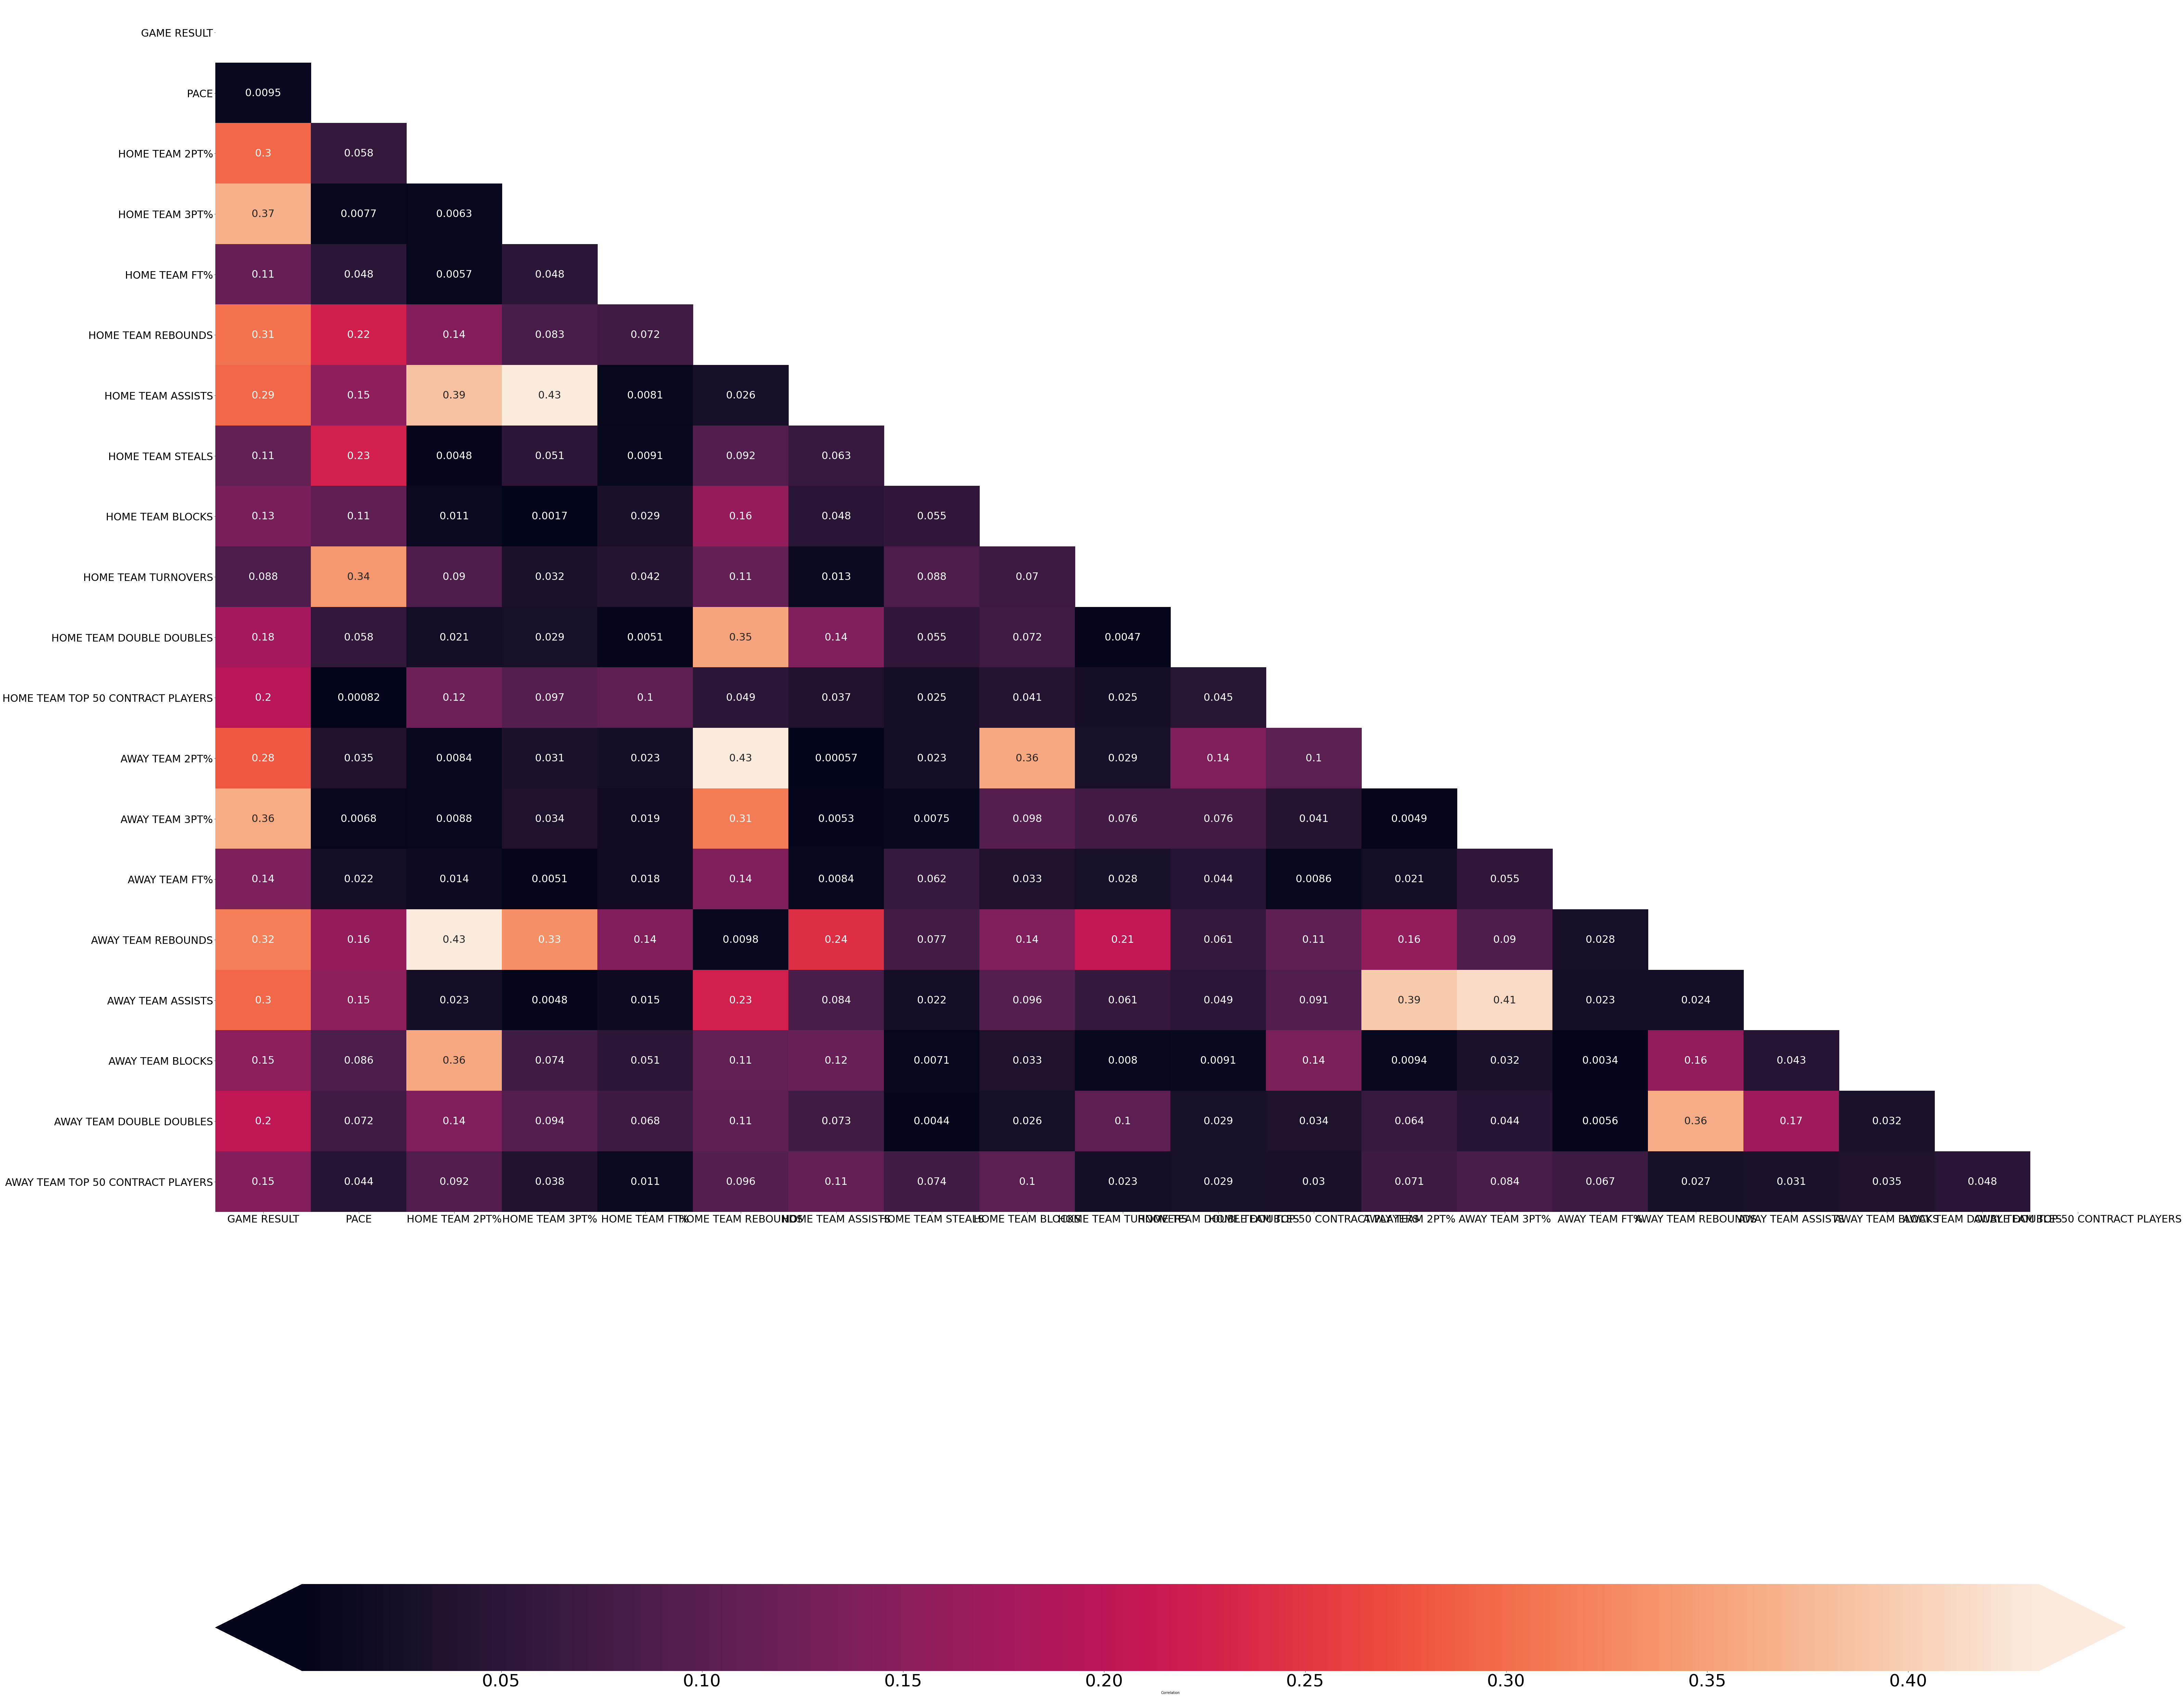

In [11]:
corr2=abs(nbadata.corr())
fig, ax = plt.subplots(figsize=(100, 100))
heat2=sns.heatmap(annot_kws={"fontsize":30},
    data=corr2,
    mask=np.triu(np.ones_like(corr2, dtype=bool)),
    ax=ax,
    annot=True,
    cbar_kws={"label": "Correlation", "orientation": "horizontal", "pad": .2, "extend": "both"}
)
ax.collections[0].colorbar.ax.tick_params(labelsize=50)
heat2.set_xticklabels(heat2.get_xmajorticklabels(), fontsize = 30)
heat2.set_yticklabels(heat2.get_ymajorticklabels(), fontsize = 30)
plt.show()

After highly correlated variables are removed, the data can now be modeled.

### First Model

The first model will be created with simple classifier binary logistic regression, done to establish baseline performance of what a predictive model would look like. The following process depicts parsing out the data into training and test groups, done to perceive efficacy of a classifier across 2 different groups. The classifier will assign 1 as a prediction if the home team ends up winning, and 0 as a prediction if the away team ends up winning

In [12]:
nbadata.columns

Index(['GAME RESULT', 'PACE', 'HOME TEAM 2PT%', 'HOME TEAM 3PT%',
       'HOME TEAM FT%', 'HOME TEAM REBOUNDS', 'HOME TEAM ASSISTS',
       'HOME TEAM STEALS', 'HOME TEAM BLOCKS', 'HOME TEAM TURNOVERS',
       'HOME TEAM DOUBLE DOUBLES', 'HOME TEAM TOP 50 CONTRACT PLAYERS',
       'AWAY TEAM 2PT%', 'AWAY TEAM 3PT%', 'AWAY TEAM FT%',
       'AWAY TEAM REBOUNDS', 'AWAY TEAM ASSISTS', 'AWAY TEAM BLOCKS',
       'AWAY TEAM DOUBLE DOUBLES', 'AWAY TEAM TOP 50 CONTRACT PLAYERS'],
      dtype='object')

In [13]:
y=nbadata['GAME RESULT']
X=nbadata.drop(columns=['GAME RESULT'], axis=1)

X = X.apply(lambda x: (x-x.min())/(x.max()-x.min()),axis=0)
X.head()

#normalizing data

,PACE,HOME TEAM 2PT%,HOME TEAM 3PT%,HOME TEAM FT%,HOME TEAM REBOUNDS,HOME TEAM ASSISTS,HOME TEAM STEALS,HOME TEAM BLOCKS,HOME TEAM TURNOVERS,HOME TEAM DOUBLE DOUBLES,HOME TEAM TOP 50 CONTRACT PLAYERS,AWAY TEAM 2PT%,AWAY TEAM 3PT%,AWAY TEAM FT%,AWAY TEAM REBOUNDS,AWAY TEAM ASSISTS,AWAY TEAM BLOCKS,AWAY TEAM DOUBLE DOUBLES,AWAY TEAM TOP 50 CONTRACT PLAYERS
0,0.363889,0.707960,0.446733,0.578704,0.456522,0.350,0.363636,0.25,0.481481,0.00,0.2,0.337874,0.525665,0.582418,0.390244,0.363636,0.466667,0.25,0.4
1,0.555556,0.392667,0.438605,0.771930,0.717391,0.325,0.318182,0.15,0.555556,0.25,1.0,0.257705,0.572562,0.780769,0.682927,0.666667,0.600000,0.25,0.4
2,0.638889,0.479041,0.591760,0.388889,0.521739,0.225,0.363636,0.45,0.555556,0.25,0.2,0.429266,0.373754,0.686813,0.658537,0.454545,0.266667,0.25,0.4
3,0.538889,0.492443,0.728746,0.729167,0.369565,0.450,0.136364,0.20,0.666667,0.25,0.2,0.480039,0.369898,0.734266,0.585366,0.515152,0.266667,0.25,0.0
4,0.597222,0.672040,0.363949,0.737374,0.478261,0.175,0.272727,0.25,0.666667,0.00,0.2,0.414034,0.317322,0.756410,0.536585,0.545455,0.200000,0.50,0.2


The data is then normally scaled using the min/max of each column. This is done in order to optimize performance, since there is a high amount of variablility within the scale of our variables, as seen by the .describe() code. 

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=0)

logreg=LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear')
logreg.fit(X_train,y_train)
y_hat_train=logreg.predict(X_train)
y_hat_test=logreg.predict(X_test)

X.columns

Index(['PACE', 'HOME TEAM 2PT%', 'HOME TEAM 3PT%', 'HOME TEAM FT%',
       'HOME TEAM REBOUNDS', 'HOME TEAM ASSISTS', 'HOME TEAM STEALS',
       'HOME TEAM BLOCKS', 'HOME TEAM TURNOVERS', 'HOME TEAM DOUBLE DOUBLES',
       'HOME TEAM TOP 50 CONTRACT PLAYERS', 'AWAY TEAM 2PT%', 'AWAY TEAM 3PT%',
       'AWAY TEAM FT%', 'AWAY TEAM REBOUNDS', 'AWAY TEAM ASSISTS',
       'AWAY TEAM BLOCKS', 'AWAY TEAM DOUBLE DOUBLES',
       'AWAY TEAM TOP 50 CONTRACT PLAYERS'],
      dtype='object')

In [15]:
residuals1 = np.abs(y_train - y_hat_train)

print('Train Data Classifier Results')
print('___________________')
print(pd.Series(residuals1).value_counts(normalize=True))


residuals2=np.abs(y_test - y_hat_test)

print('Test Data Classifier Results')
print('___________________')
print(pd.Series(residuals2).value_counts(normalize=True))

Train Data Classifier Results
___________________
0    0.907825
1    0.092175
Name: GAME RESULT, dtype: float64
Test Data Classifier Results
___________________
0    0.879233
1    0.120767
Name: GAME RESULT, dtype: float64


Above the LogisticRegression is instantiated, with a high C hyperparameter value. A high value of C tells the model to give heavy focus on the training data, and a lower weight to the complexity penalty. The data was already scaled using the lambda function so C can be a large value, since the training data should be trusted. The regression model is used to predict using both the train and test data. 

Looking at the calculated residuals between training and test results, it seems like our model is overfitted on the training data. The residual performance is 3% higher for the training data. Overall however, our model seems to be highly effective at calculating game results, as seen by the high % correct. This will likely change in the event of adding hyperparameters to this model in order to change overfitting.

Below, results of the first model can be seen through the model's classification report. The classification report outputs 3 metrics of critical importance: precision, recall, accuracy, and f1 score. 

These main metrics help understand how well the model performed in terms of classifying each game as a win/loss. 

### Precision: 
Precision measures how precise the predictions are. Precision is calculated by taking the number of true home team game wins, and dividing by the number of home team game wins predicted by the model. 

### Recall: 
Recall measures what % of the games identified as a win were actually identified correctly. Recall is calculated by dividing the number of total true home team game wins identified by the model, by the number of actual home team game wins. 

### Accuracy:
Accuracy evaluates all predictions within the model. Accuracy is calculated by dividing the total correct predictions from the model (both wins/losses) by the total records in the original dataset. 

### F1 Score:
F1 Score takes both precision and recall into account to get a cumulative score. The formula is calculated as follows: 2*(precision * recall)/(precision + recall). This metric is a good measure of overall model performance, as a high F1 score implies both precision and recall are both high as well. 

In [16]:
reporttest1=classification_report(y_test, y_hat_test)
reporttrain1=classification_report(y_train, y_hat_train)

print('Test Data Classification Report')
print('_________________________________')
print(reporttest1)
print('Training Data Classification Report')
print('_________________________________')
print(reporttrain1)

Test Data Classification Report
_________________________________
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       393
           1       0.88      0.91      0.89       493

    accuracy                           0.88       886
   macro avg       0.88      0.88      0.88       886
weighted avg       0.88      0.88      0.88       886

Training Data Classification Report
_________________________________
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      1217
           1       0.91      0.92      0.92      1441

    accuracy                           0.91      2658
   macro avg       0.91      0.91      0.91      2658
weighted avg       0.91      0.91      0.91      2658



As seen above, the initial model performs relatively well on the test data, seen from the predicted values. 
F1 score is relatively high for both home team losses & wins classifications, implying succesful precision and recall values as well.
Looking at the overall accuracy, across all observations, our model performed exceptionally well too. 

The corresponding confusion matrices, seen below, re-interprets the information above in clean visuals, showing how the model classifies the test/train data using the logistic regression classifier trhough counts of true/false positives/negatives. 

### LEGEND:

0 in True label, 0 in Predicted label - True Negative

0 in True label, 1 in Predicted label - False Positive

1 in True label, 1 in Predicted label - True Positive

1 in True label, 0 in Predicted label - False Negative


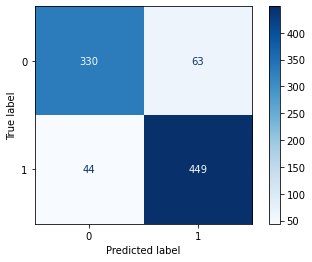

In [17]:
cnf_matrixtest1=plot_confusion_matrix(logreg, X_test, y_test, cmap=plt.cm.Blues)
cnf_matrixtest1

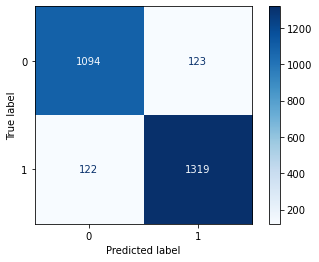

In [18]:
cnf_matrixtrain1=plot_confusion_matrix(logreg, X_train, y_train, cmap=plt.cm.Blues)
cnf_matrixtrain1

In [19]:
residuals1=np.abs(y_test - y_hat_test)

print('Test Data Classifier Results')
print('___________________')
print(pd.Series(residuals1).value_counts(normalize=True))

print('___________________')

residuals2 = np.abs(y_train - y_hat_train)

print('Train Data Classifier Results')
print('___________________')
print(pd.Series(residuals2).value_counts(normalize=True))


Test Data Classifier Results
___________________
0    0.879233
1    0.120767
Name: GAME RESULT, dtype: float64
___________________
Train Data Classifier Results
___________________
0    0.907825
1    0.092175
Name: GAME RESULT, dtype: float64


Seen from both plotted matrices and the calculated residuals (showing the same information summarized), the amount of accurately predicted counts is relatively proportional between the train and test data. The model appears to be slightly overfit on the training data, seen by the slightly higher % of residual value counts within the training data (90.7%). This implies that further application of parameters would help maintain overall model performance between train/test data while reducing overfitting. 

### Second Model

A Decision Tree classifier is applied to the dataset, in order to get the perspective of a different model. A Decision Tree is comprised of different decisions that originate from the overall sample space. These decisions will be used to parse the data out, eventually getting to a granularity where the final nodes/groups of data can be classified. With metrics like 3PT% and rebounds being critical to success, decisions done based on these would be interesting to see. Below, the DecisionTreeClassifier is instantiated for use, and the game result is predicted based on the separated test data.

In [20]:
classifier=DecisionTreeClassifier(random_state=10)
classifier.fit(X_train,y_train)

y_hat_train2=classifier.predict(X_train)
y_hat_test2=classifier.predict(X_test)

In [21]:
reporttest2=classification_report(y_test, y_hat_test2)
reporttrain2=classification_report(y_train, y_hat_train2)

print('Test Data Classification Report')
print('_________________________________')
print(reporttest2)
print('Training Data Classification Report')
print('_________________________________')
print(reporttrain2)

Test Data Classification Report
_________________________________
              precision    recall  f1-score   support

           0       0.72      0.68      0.70       393
           1       0.75      0.79      0.77       493

    accuracy                           0.74       886
   macro avg       0.74      0.73      0.74       886
weighted avg       0.74      0.74      0.74       886

Training Data Classification Report
_________________________________
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1217
           1       1.00      1.00      1.00      1441

    accuracy                           1.00      2658
   macro avg       1.00      1.00      1.00      2658
weighted avg       1.00      1.00      1.00      2658



As seen above, the second model has dropped to ~.74 accuracy in predicting game outcomes. This may seem like a drastic change which invalidates the model, but as explained in later sections, an accuracy close to .75 is expected when predicting NBA games. The training data scores clearly show the model is perfectly fit on the training data, with an accuracy score of 1. Parameter application in later model iterations will help reduce the overfitting.

In [22]:
residuals1=np.abs(y_test - y_hat_test2)
print('Test Data Classifier Results')
print('___________________')
print(pd.Series(residuals1).value_counts(normalize=True))

print('___________________')

residuals2 = np.abs(y_train - y_hat_train2)
print('Train Data Classifier Results')
print('___________________')
print(pd.Series(residuals2).value_counts(normalize=True))

Test Data Classifier Results
___________________
0    0.740406
1    0.259594
Name: GAME RESULT, dtype: float64
___________________
Train Data Classifier Results
___________________
0    1.0
Name: GAME RESULT, dtype: float64


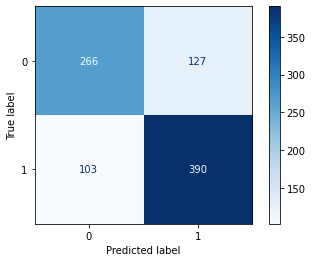

In [23]:
cnf_matrix_test2=plot_confusion_matrix(classifier, X_test, y_test, cmap=plt.cm.Blues)
cnf_matrix_test2

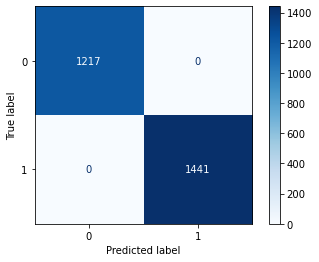

In [24]:
cnf_matrix_train2=plot_confusion_matrix(classifier, X_train, y_train, cmap=plt.cm.Blues)
cnf_matrix_train2

The matrices/residuals show a slightly less accurate model overall on the test data compared to the first model, when using a decision tree classifier.

As seen by the above classifier residuals and confusion matrix results, our prediction quality went down within the testing data. This is still a high performing model, but the fit will be optimized with the addition of hyperparameters.
Due to the lack of applied hyperparameters, the Decision Tree fit on our training data had a perfect residual score of 1,  quantifying it as overfit. 

### Third Model

The application of hyperparameters will be observed in order to improve our initial Decision Tree model and mitigate overfitting on the training data. Below, the following charts are generated amongst the training/test data using the instantiated DecisionTreeClassifier in order to identify optimal hyperparameter values that maximize both training and testing AUC. The criterion 'entropy' is selected in order to prioritize minimizing messy data, while keeping predictive power.

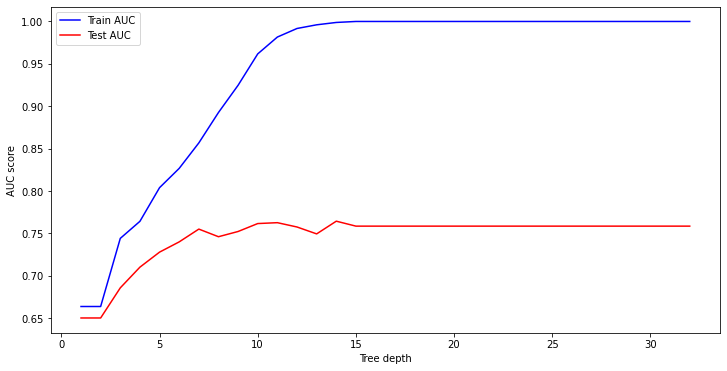

In [25]:
# Identify the optimal tree depth for given data
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
SEED=22311
for max_depth in max_depths:
   dt = DecisionTreeClassifier(criterion='entropy', max_depth=max_depth, random_state=SEED)
   dt.fit(X_train, y_train)
   train_pred = dt.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)


   train_results.append(roc_auc)
   

   y_pred = dt.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   

   test_results.append(roc_auc)

plt.figure(figsize=(12,6))
plt.plot(max_depths, train_results, 'b', label='Train AUC')
plt.plot(max_depths, test_results, 'r', label='Test AUC')
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.legend()
plt.show()

As seen above, Train AUC maximizes around a tree depth of 15, with depth specified afterwards being a perfect fit on the training data. Test AUC peaks at ~5, but the corresponding Train AUC is only .75. There is a slight peak in Test AUC where tree depth is 10, so that value will be used as the max_depth hyperparameter. 

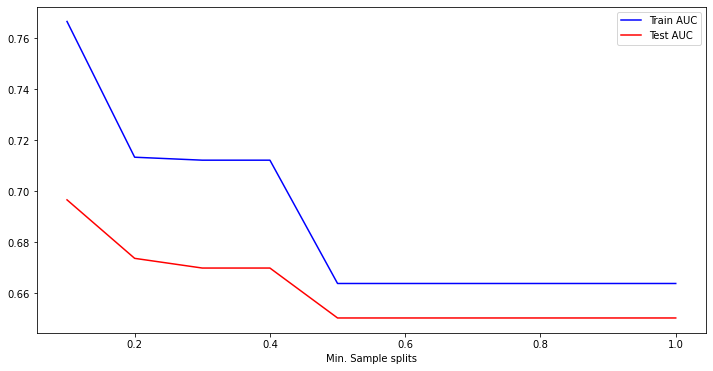

In [26]:
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
   dt = DecisionTreeClassifier(criterion='entropy', min_samples_split=min_samples_split, random_state=SEED)
   dt.fit(X_train, y_train)
   train_pred = dt.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds =    roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = dt.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

plt.figure(figsize=(12,6))
plt.plot(min_samples_splits, train_results, 'b', label='Train AUC')
plt.plot(min_samples_splits, test_results, 'r', label='Test AUC')
plt.xlabel('Min. Sample splits')
plt.legend()
plt.show()


As seen above, for both Train and Test data, a limit in min sample splits for both would severely decrease AUC for both sets. Therefore, this parameter will not be specified when instantiating the next DecisionTreeClassifier.

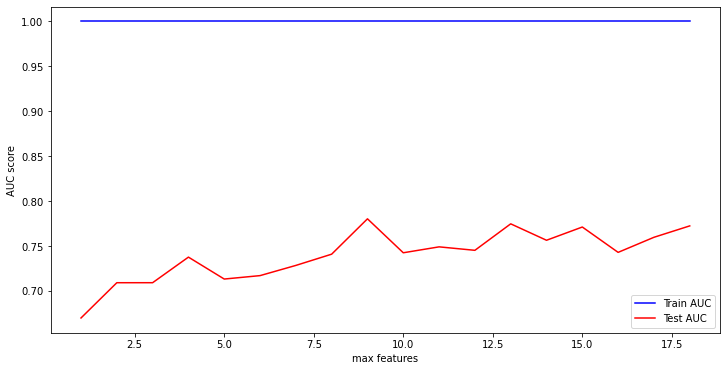

[0.6698073280378222, 0.7090668855065059, 0.7090849501158716, 0.7375728390856209, 0.7131598098570832, 0.7169766037502129, 0.7283366623827736, 0.7408554366732215, 0.7802233817980996, 0.742421896371078, 0.7490051561556447, 0.7451522330437835, 0.7746362561871287, 0.756344548875091, 0.7710955927514465, 0.7428657696297787, 0.7596452110720572, 0.7723497927731241]


In [27]:
max_features=list(range(1, X_train.shape[1]))
train_results = []
test_results = []
for max_feature in max_features:
   dt = DecisionTreeClassifier(criterion='entropy', max_features=max_feature, random_state=SEED)
   dt.fit(X_train, y_train)
   train_pred = dt.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = dt.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

plt.figure(figsize=(12,6))
plt.plot(max_features, train_results, 'b', label='Train AUC')
plt.plot(max_features, test_results, 'r', label='Test AUC')
plt.ylabel('AUC score')
plt.xlabel('max features')
plt.legend()
plt.show()


print(test_results)

For number of features, it seems like the Test AUC plateaus at ~.75, but there appears to be a bump in AUC at 9 features. Training AUC seems consistent no matter what value we choose, so 9 will be selected as the max_features hyperparameter.

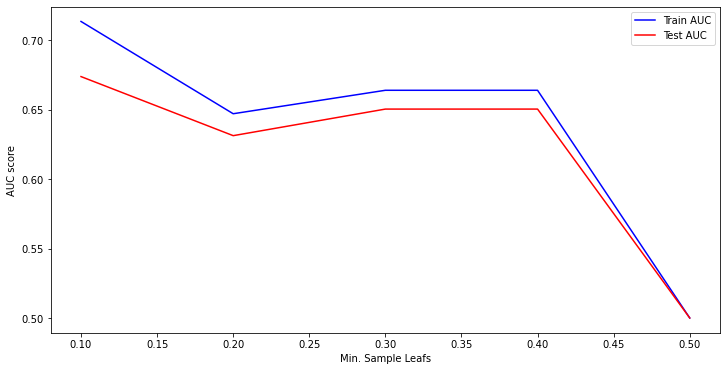

In [28]:
min_samples_leafs=np.linspace(.1,.5,5,endpoint=True)
train_results=[]
test_results=[]
for min_samples_leaf in min_samples_leafs:
    dt=DecisionTreeClassifier(criterion='entropy', min_samples_leaf=min_samples_leaf, random_state=SEED)
    dt.fit(X_train,y_train)
    train_pred=dt.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds=roc_curve(y_train, train_pred)
    roc_auc=auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred=dt.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds=roc_curve(y_test, y_pred)
    roc_auc=auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
    
    
plt.figure(figsize=(12,6))    
plt.plot(min_samples_leafs, train_results, 'b', label='Train AUC')
plt.plot(min_samples_leafs, test_results, 'r', label='Test AUC')
plt.ylabel('AUC score')
plt.xlabel('Min. Sample Leafs')
plt.legend()
plt.show()

Similar to the results seen in the plotted min_samples_split chart, a limit in min sample leafs for both would severely decrease AUC for both sets. In order to reduce overfitting, however, a limit of .1 will be applied in order to reduce the overfitting further.

In [29]:
dt2 = DecisionTreeClassifier(criterion='entropy', max_features=9, max_depth=10, min_samples_leaf=.1, random_state=10)
dt2.fit(X_train,y_train)
y_hat_test3=dt2.predict(X_test)
y_hat_train3=dt2.predict(X_train)

In [30]:
reporttest3=classification_report(y_test, y_hat_test3)
reporttrain3=classification_report(y_train, y_hat_train3)

print('Test Data Classification Report')
print('_________________________________')
print(reporttest3)
print('Training Data Classification Report')
print('_________________________________')
print(reporttrain3)

Test Data Classification Report
_________________________________
              precision    recall  f1-score   support

           0       0.75      0.57      0.65       393
           1       0.71      0.85      0.77       493

    accuracy                           0.72       886
   macro avg       0.73      0.71      0.71       886
weighted avg       0.73      0.72      0.72       886

Training Data Classification Report
_________________________________
              precision    recall  f1-score   support

           0       0.74      0.60      0.67      1217
           1       0.71      0.83      0.76      1441

    accuracy                           0.72      2658
   macro avg       0.73      0.71      0.71      2658
weighted avg       0.73      0.72      0.72      2658



As seen above, the application of all hyperparameters specified maintained the accuracy within the testing data relatively well, while also greatly reducing the overfitting seen within the training data.

For the test data, recall was far higher than precision for win predictions, which implies the model was better at correctly identifying true game wins, rather than predicting whether a win happened. On the contrary, recall for loss predictions was far lower. This means the model tends to favor assigning false positive home team wins.

For the training data, similar trends can be seen within precision, recall, and f1-score for win/loss predictions, which makes the model performance relatively similar between train/test data. This means that the overfitting issue seen in the prior decision tree model has been fully mitigated.

In [31]:
residuals2=np.abs(y_test - y_hat_test3)
print('Test Data Classifier Results')
print('___________________')
print(pd.Series(residuals2).value_counts(normalize=True))

print('___________________')

residuals1 = np.abs(y_train - y_hat_train3)
print('Train Data Classifier Results')
print('___________________')
print(pd.Series(residuals1).value_counts(normalize=True))

Test Data Classifier Results
___________________
0    0.723476
1    0.276524
Name: GAME RESULT, dtype: float64
___________________
Train Data Classifier Results
___________________
0    0.722724
1    0.277276
Name: GAME RESULT, dtype: float64


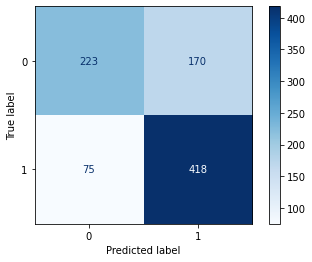

In [32]:
cnf_matrix_test3=plot_confusion_matrix(dt2, X_test, y_test, cmap=plt.cm.Blues)
cnf_matrix_test3

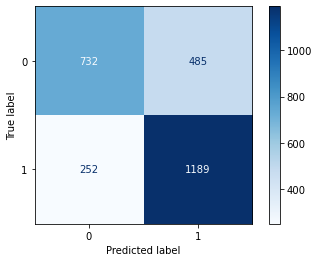

In [33]:
cnf_matrix_train3=plot_confusion_matrix(dt2, X_train, y_train, cmap=plt.cm.Blues)
cnf_matrix_train3

Resulting residuals and confusion matrices both illustrate the improvement in reduction of overfitting within the initial Decision Tree model when hyperparameters are added. The classifier now predicts with an accuracy of 72% with both the training data and test data.

Below, the defined __plot_feature_importances__ function will allow us to see the individual contribution of each predictor in our model.

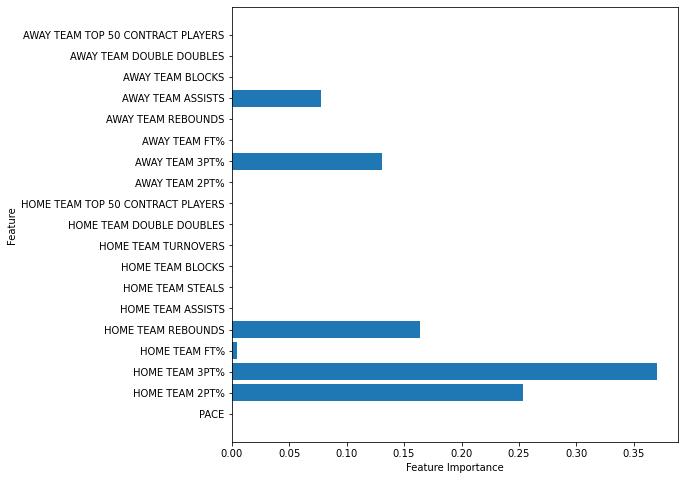

In [34]:
def plot_feature_importances(model):
    n_features = X.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X.columns.values) 
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')

plot_feature_importances(dt2)

Seen above, the most impactful features in the model involve playmaking on the offensive end, and overall metrics that contribute to a team's final score. Since the 3 point shot offers the highest potential for scoring (4 points, if fouled on the made shot attempt) it is unsurprising that 3PT% is directly equated to win percentage. Similarly, 2 PT field goals (2PT%) are the standard/easiest route of scoring for most teams in the NBA. It seems that assists and rebounds are highlighted to a degree as well. 

### Fourth Model

Next, the RandomForestClassifier will be tested for efficacy comparison amongst the other models. This model will be interesting to evaluate against, as it contains multiple Decision Trees in order to eliminate bias amongst individual trees. Each individual decision tree is based on a different subset of data so the resulting output will be a composite of several decisions. The nature of having multiple trees assists with reducing overfitting within the eventual output. The plan is to use now use GridSearchCV to identify optimal hyperparameters within the forest, for a more optimized method in replicating the same overfitting-reduction results in the prior model. 

In [35]:
depth = [i for i in range(6,11,1)]
features=[i for i in range(3,8,1)]

# Create the dictionary with parameters to be checked
parameters = dict(max_depth=depth, max_features=features, min_samples_leaf=[.1,.2,.25],min_samples_split=[.1,.2,.3])
forest2=RandomForestClassifier(random_state=11)

search=GridSearchCV(forest2,parameters,cv=3,return_train_score=True)
search.fit(X_train,y_train)

trainscore=np.mean(search.cv_results_['mean_train_score'])
testscore=search.score(X_test,y_test)
print(f"mean train score: {trainscore}")
print(f"mean test score: {testscore}")


search.best_params_


mean train score: 0.75945573112616
mean test score: 0.7708803611738149


{'max_depth': 6,
 'max_features': 5,
 'min_samples_leaf': 0.1,
 'min_samples_split': 0.1}

As seen from the best_params_ output from the GridSearchCV, the ideal parameters are applied to the RandomForestClassifier below, seeing as they maximized both while reducing overfitting in the model. 

{'max_depth': 10,
 'max_features': 6,
 'min_samples_leaf': 0.2,
 'min_samples_split': 0.1}

In [36]:
forest=RandomForestClassifier(criterion='entropy', max_features=5, max_depth=6, min_samples_leaf=.1, min_samples_split=0.1, random_state=11)
forest.fit(X_train, y_train)
y_hat_test4=forest.predict(X_test)
y_hat_train4=forest.predict(X_train)

reporttest4=classification_report(y_test, y_hat_test4)
reporttrain4=classification_report(y_train, y_hat_train4)


print('Test Data Classification Report')
print('_________________________________')
print(reporttest4)
print('Training Data Classification Report')
print('_________________________________')
print(reporttrain4)


Test Data Classification Report
_________________________________
              precision    recall  f1-score   support

           0       0.81      0.64      0.71       393
           1       0.75      0.88      0.81       493

    accuracy                           0.77       886
   macro avg       0.78      0.76      0.76       886
weighted avg       0.78      0.77      0.77       886

Training Data Classification Report
_________________________________
              precision    recall  f1-score   support

           0       0.82      0.72      0.77      1217
           1       0.79      0.87      0.83      1441

    accuracy                           0.80      2658
   macro avg       0.81      0.80      0.80      2658
weighted avg       0.80      0.80      0.80      2658



Compared to the prior Decision Tree model with applied hyperparameters, this is a clear improvement in performance. Recall in the loss predictions went up comparatively, making the overall accuracy of the test model ~80%, and the accuracy of the training model ~77%.

For the test data, recall was far higher than precision in the win predictions, which implies the model was better at correctly identifying true game wins, rather than predicting whether a win happened. The loss predictions show a drop in recall compared to the third model. This shows that our model is identifying a higher amount of false positive wins. 

For the training data, a similar trend can be seen, but slightly higher precision in the loss predictions led to a higher overall f1 score & accuracy.

The ~3% discrepancy between train/test accuracy can be chalked up to noise/slight overfitting in the training data. This model still preserved accuracy seen in Model 3, while keeping loss recall relatively high.

In [37]:
residuals2=np.abs(y_test - y_hat_test4)
print('Test Data Classifier Results')
print('___________________')
print(pd.Series(residuals2).value_counts(normalize=True))

print('___________________')

residuals1 = np.abs(y_train - y_hat_train4)
print('Train Data Classifier Results')
print('___________________')
print(pd.Series(residuals1).value_counts(normalize=True))

Test Data Classifier Results
___________________
0    0.773138
1    0.226862
Name: GAME RESULT, dtype: float64
___________________
Train Data Classifier Results
___________________
0    0.801731
1    0.198269
Name: GAME RESULT, dtype: float64


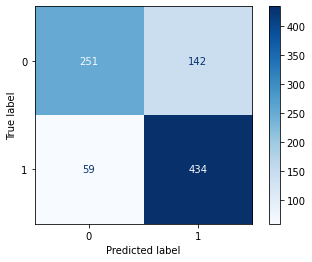

In [38]:
cnf_matrix_test4=plot_confusion_matrix(forest, X_test, y_test, cmap=plt.cm.Blues)
cnf_matrix_test4

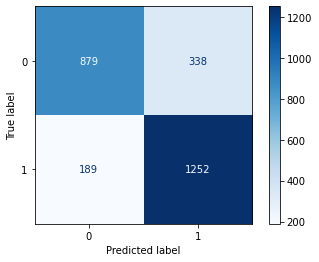

In [39]:
cnf_matrix_train4=plot_confusion_matrix(forest, X_train, y_train, cmap=plt.cm.Blues)
cnf_matrix_train4

The difference between test and train data residuals is still minimal, similar to the third model, but overall accuracy went up slightly for both sets. This may be due the inclusion of multiple trees having an influence in the decision making, rather than just one. 

As shown by the confusion matrices, the model is now outputting a lower amount of false positive game wins, seen by the top right squares. This further validates the model, it being the most successful identifying true wins compared to prior models.

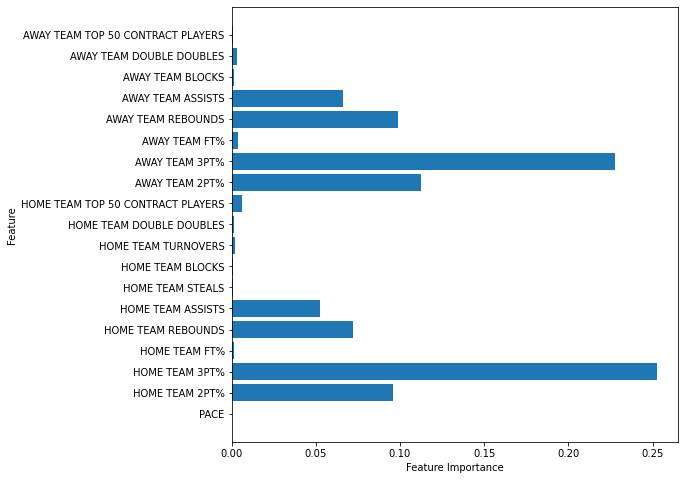

In [40]:
plot_feature_importances(forest)

Similarly to the initial Decision Tree model, the Random Forest model highlights the same features of importance within determining game wins: 3PT%, 2PT%, assists, and rebounds. 

The __TOP 50 CONTRACT PLAYERS__ being recognized as a feature of importance within the forest shows the effect a player with a max contract can have on game win %. Typically, NBA management will only give these kinds of contracts to players who they can build teams around. The max contract players will typically stay with the team for at least 2 years, and more often than not, are their main scorers.

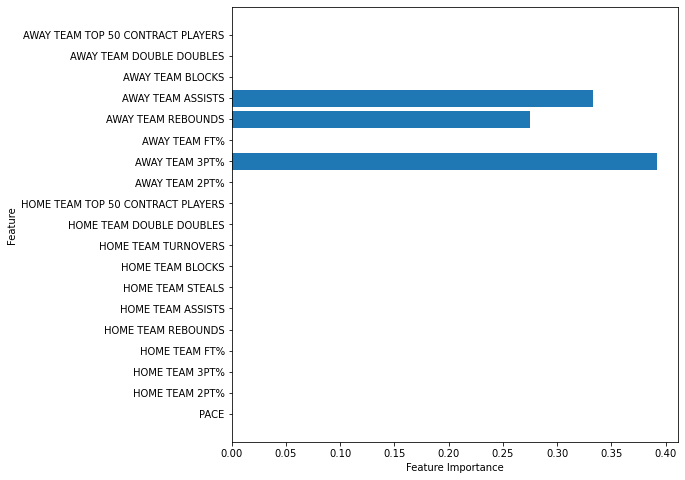

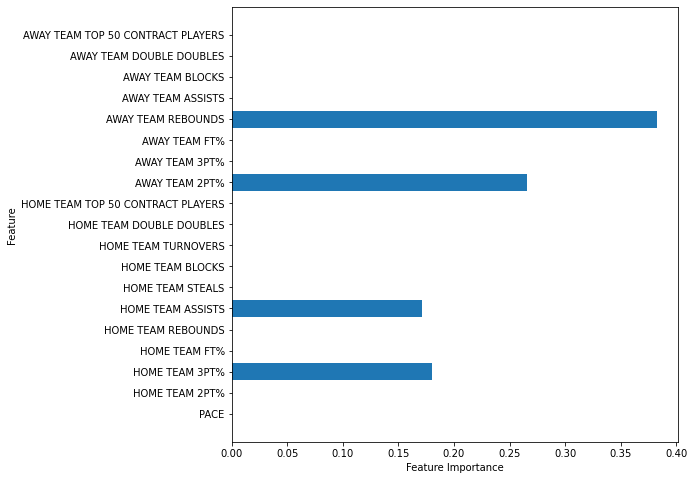

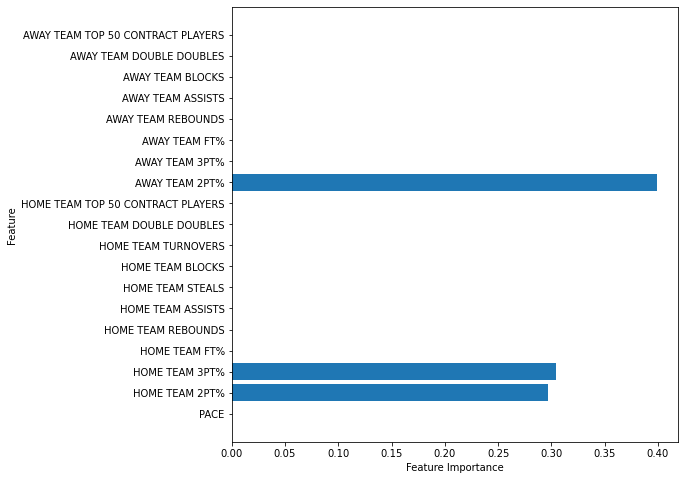

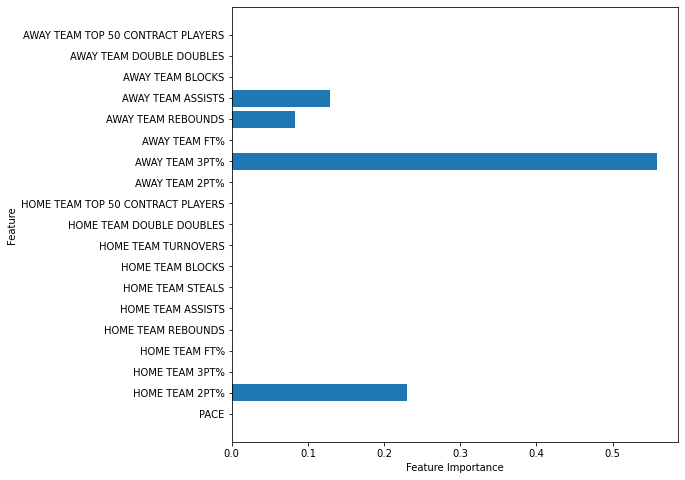

In [41]:
rf_tree_1=forest.estimators_[0]
rf_tree_2=forest.estimators_[1]
rf_tree_3=forest.estimators_[2]
rf_tree_4=forest.estimators_[3]

plot_feature_importances(rf_tree_1)
plot_feature_importances(rf_tree_2)
plot_feature_importances(rf_tree_3)
plot_feature_importances(rf_tree_4)

When looking at the individual trees, we can see that each tree highlights a combination of important metrics in the overall forest contributing to team wins. 

### Fifth Model

Finally, the XGBoost model will be used as a final comparison to our prior models. XGBoost is the top gradient boosting algorithm, used on trees in order to strengthen poor performing ones. A GridSearchCV parameter grid search will be used to tune the algorithm and identify ideal hyperparameters.

In [42]:
rate=[.4,.3,.5]
depth = [i for i in range(6,10,1)] 

parameters2 = dict(learning_rate=rate, max_depth=depth,min_child_weight=[2,3,4],subsample=[.3,.5,.7])
clf=XGBClassifier()

search2=GridSearchCV(clf,parameters2,cv=3,return_train_score=True)
search2.fit(X_train,y_train)

trainscore2=np.mean(search2.cv_results_['mean_train_score'])
testscore2=search2.score(X_test,y_test)
print(f"mean train score: {trainscore2}")
print(f"mean test score: {testscore2}")

search2.best_params_

C:\Users\noahi\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:11:27] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:11:27] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:11:27] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:11:27] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[01:11:30] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:11:30] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:11:30] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:11:30] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[01:11:33] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:11:34] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:11:34] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:11:34] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[01:11:37] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:11:37] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:11:37] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:11:37] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[01:11:40] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:11:41] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:11:41] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:11:41] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[01:11:44] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:11:45] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:11:45] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:11:45] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[01:11:48] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:11:48] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:11:48] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:11:48] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[01:11:52] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:11:52] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:11:52] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:11:52] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[01:11:55] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:11:55] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:11:55] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:11:55] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[01:11:58] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:11:59] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:11:59] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:11:59] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

{'learning_rate': 0.4, 'max_depth': 9, 'min_child_weight': 3, 'subsample': 0.5}

In [43]:
clf=XGBClassifier(max_depth=9,learning_rate=0.4,min_child_weight=3, subsample=0.5)
clf.fit(X_train,y_train)
y_hat_test5=clf.predict(X_test)
y_hat_train5=clf.predict(X_train)

reporttest5=classification_report(y_test, y_hat_test5)
print(reporttest5)

reporttrain5=classification_report(y_train, y_hat_train5)
print(reporttrain5)

[01:12:01] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.84      0.80      0.82       393
           1       0.85      0.88      0.86       493

    accuracy                           0.85       886
   macro avg       0.84      0.84      0.84       886
weighted avg       0.85      0.85      0.84       886

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1217
           1       1.00      1.00      1.00      1441

    accuracy                           1.00      2658
   macro avg       1.00      1.00      1.00      2658
weighted avg       1.00      1.00      1.00      2658



While the test data shows the best modeled results thus far, the model is overfit on the training data, seen by the perfect accuracy score.

In [44]:
residuals2=np.abs(y_test - y_hat_test5)
print('Test Data Classifier Results')
print('___________________')
print(pd.Series(residuals2).value_counts(normalize=True))

print('___________________')

residuals1 = np.abs(y_train - y_hat_train5)
print('Train Data Classifier Results')
print('___________________')
print(pd.Series(residuals1).value_counts(normalize=True))

Test Data Classifier Results
___________________
0    0.845372
1    0.154628
Name: GAME RESULT, dtype: float64
___________________
Train Data Classifier Results
___________________
0    0.999624
1    0.000376
Name: GAME RESULT, dtype: float64


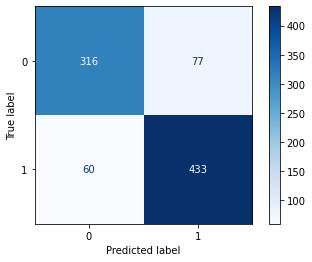

In [45]:
cnf_matrix_test5=plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues)
cnf_matrix_test5

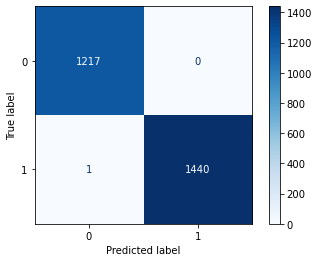

In [46]:
cnf_matrix_train5=plot_confusion_matrix(clf, X_train, y_train, cmap=plt.cm.Blues)
cnf_matrix_train5

Residuals further support the near perfect model fit, but the predictions on the test data were the best overall, showing minimal false positives/false negatives amongst the test data.

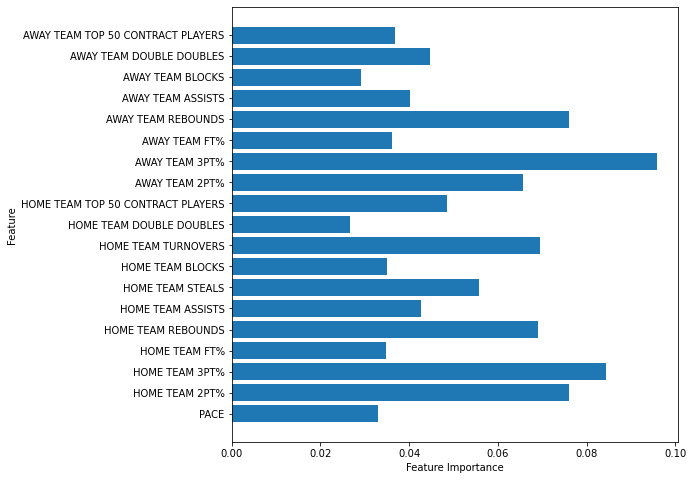

In [47]:
plot_feature_importances(clf)

Feature importance seems to take all possible metrics into account to a degree, but the prior metrics identified, 3PT%, 2PT%, and rebounds still appear to be the most prominent.


Seen from the above results, the model overfit on the training data, despite having a high accuracy when applying the model to the testing set. That being said, the Decision Tree (with identified hyperparameters) will be used as our final model, as it mitigated overfitting in the test/training data split while keeping overall accuracy high.


#  Classifier Results Evaluation

There are several factors that go into determining a typical NBA game win. In order to find the ideal factors that are critical to the determination of game wins, the performed analysis/model creation using the 2019-2022 NBA dataset revealed the scale/importance of several of these key metrics. The final model created, a Random Forest Classifier with applied hyperparameters, was able to predict NBA game wins with an accuracy of 77% for test data and 80% for training data. 

A classification report of the Random Forest classifier model can be seen below across the test/train datasets.

In [48]:
print('Test Data Classification Report')
print('_________________________________')
print(reporttest4)
print('Training Data Classification Report')
print('_________________________________')
print(reporttrain4)

Test Data Classification Report
_________________________________
              precision    recall  f1-score   support

           0       0.81      0.64      0.71       393
           1       0.75      0.88      0.81       493

    accuracy                           0.77       886
   macro avg       0.78      0.76      0.76       886
weighted avg       0.78      0.77      0.77       886

Training Data Classification Report
_________________________________
              precision    recall  f1-score   support

           0       0.82      0.72      0.77      1217
           1       0.79      0.87      0.83      1441

    accuracy                           0.80      2658
   macro avg       0.81      0.80      0.80      2658
weighted avg       0.80      0.80      0.80      2658



For the test data, recall was far higher than precision for win predictions, which implies the model was better at correctly identifying true game wins, rather than predicting whether a win happened. On the contrary, recall for loss predictions was far lower. This means the model tends to favor assigning false positive home team wins. The tendency to designate false positive wins can be overlooked since the recall % of overall home team wins was high, which is the main target metric of success within the model. 

For the training data, similar trends can be seen within precision, recall, and f1-score for win/loss predictions, which makes the model performance relatively similar between train/test data. Both test/training predictions having ~80% accuracy implies that the overfitting issue seen in all prior models on the training data have been mostly mitigated. While an 80% accuracy across both test/training data may be seen as a poorly performing model, NBA games have a typical upset (where the non-favored team ends up winning) rate of 32%. This is understandable when looking at examples in recent years, such as the Toronto Raptors' 2019 NBA Finals win against the favored Golden State Warriors, and the Boston Celtics 4-0 playoff sweep against the favored Brooklyn Nets. That being said, the current accuracy rate with this model is to be expected. 

Below, the calculated score importance of each feature in the dataset shows which features were the most impactful in making the model decisions. 

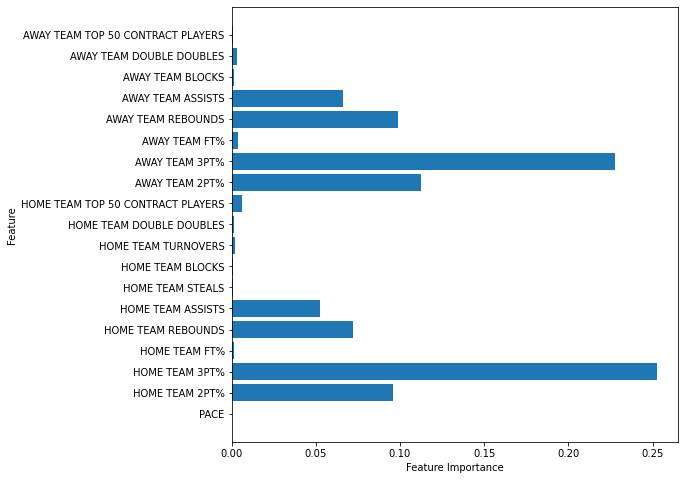

In [49]:
plot_feature_importances(forest)

## 3PT and 2PT Percentages

Seen above, the most impactful features in the model have to do with playmaking on the offensive end. Since the 3 point shot offers the highest potential for scoring (4 points, if fouled on the made shot attempt) it is unsurprising that this percentage is most equated to win rate. Similarly, 2 PT field goals are the standard/easiest route of scoring for most teams in the NBA. Nearly all of NBA players have a higher average 2 PT % compared to their 3 PT %, so the importance is less impactful. It is far rarer to have a consistent and efficient 3 point shooter on most teams, so scoring ability in that regard is highly valued. Players that can take advantage of both field goal percentages inherently have more scoring potential, and are offensive assets. More often than not, these scorers typically have the highest value contracts, are all-star selections/candidates, and are starters for their team. Some of the most prolific scorers/shooters active in the NBA are Stephen Curry, Kevin Durant, Giannis Antentokounmpo, Joel Embiid, and Nikola Jokic. All of the named players have been on teams that have made deep NBA playoff runs in recent years. 

Stephen Curry in particular is widely regarded as one of the most efficient 3PT shooters of all time, holding the current all-time NBA made 3PT shot record at 3,117. He has won NBA championships with the Warriors in 2015, 2017, and 2018.

Kevin Durant's play style, athleticism, and build have made him one of the most difficult NBA players to guard; his ability to create open shot opportunities from the 3PT and 2PT range is fundamental to his role as a scorer.  He has played a pivotal role in the success of the Oklahoma City Thunder, Golden State Warriors, and Brooklyn Nets franchises.

Giannis Antentokounpo, Nikola Jokic, and Joel Embiid were all MVP (most valuable player) candidates for the 2021-2022 season; Jokic was awarded the title in 2021 and 2022, and Giannis was awarded the title in 2020 and 2019. The imposing builds of all 3 of these "big men" make them nearly impossible to guard when in the "paint"/driving to the rim. 


## Rebounds

Total team rebounds are seen as an important factor as well. This makes sense, as the more that a defending team is able to regain possession during a game, the more opportunities that creates for that team to score on a fast break, before the other team has a chance to reset their defense. Similarly, the more that a team can rebound on the offensive end, the more they can prevent the other team from taking possession and scoring points. Current rebound leaders in the NBA include Rudy Gobert, Nikola Jokic, Giannis Antentokounmpo, and Joel Embiid. 

Rudy Gobert has played a pivotal role for the Utah Jazz on the defensive end, having a career average of almost 12 rebounds per game. His high rebound/block rates have earned him the DPOY (Defensive Player of the Year) award 3 times in the past 4 years. 

As previously mentioned, Giannis, Jokic, and Embiid were all MVP candidates for the 2021-2022 NBA season, with Jokic winning the title. It is natural that players who can be assets on both offensive and defensive ends of the court are highly valued. 


## Assists

Assists are high in importance as well. Players that don't have as strong of an affinity for scoring can still be valued if they can create plays for their teammates through their passing ability/leadership. This leads to an increase in a team's resulting scores. Assists as a whole can be used to identify how well a team works together in order to score. The more assists a team has by the end of the game either highlights a team's consistent offense, or an opposing team's lackluster defense. Current assist leaders in the NBA include Chris Paul, Lebron James, and Luka Doncic.

Chris Paul has been in the top 20 season APG (assists per game) ranking list for the past 10 years. His ability to create shot opportunites for his teammates has led the Phoenix Suns to the NBA finals in 2021, and the playoffs in 2022.

Lebron James has been widely regarded as the GOAT (Greatest of all Time) by many NBA fans, and for good reason. His ability as a scorer/team leader has led him to 4 NBA championships with the Cleveland Cavaliers, the Miami Heat, and the Los Angeles Lakers.

## Recommendations/Conclusion


NBA analysts have the difficult job of determining accurate predictions/takes in a game so highly sensitive as basketball. They are undoubtedly placed under a lot of scrutiny, as their job title inherently implies a strong understanding of the current game state. Several analysts, such as Kendrick Perkins, are known to have particularly terrible takes. 
An analyst’s success, whether that be through roles on online media, print publications, or television programs, is directly correlated to their baseline udnerstanding of math, statistics, and current/past NBA knowledge. Knowledge of game metrics and the effect they have on a win/loss result is critical to their success. 

The created model to help analysts identify crucial metrics is able to predict game wins/losses for the home team given a total set of 19 metrics, with ~80% accuracy. The state of the model is optimal, as the typical NBA upset rate is ~32%, which means that 32% of the time, the predicted favored team (based on pre-existing metrics) will end up losing. Model performance is about the same between test/training sets which means that the model’s success isn’t heavily reliant on the data used to train it, and will perform relatively well in the face of new data. 

The model identified the following stats as critical in determining game wins, in order of importance: 3 Point %, 2 Point %, Rebounds, and Assists. Although the feature importance diagram specifically lists home/away team designations, these designations should be ignored when evaluating overall model performance; it can be assumed that assists/rebounds generally both contribute to win rates. 

Translating these findings to nightly game predictions, if 2 teams are facing off, the team with the overall higher scoring percentages, particularly when it comes to 3PT shots should have the better odds of winning. If these metrics are similar/inconsistent for both teams, the team with the higher rate of rebounds should be identified as more likely to win. Rebounds are a clear indicator of how well a team is able to maintain ball possession, on both the offensive/defensive ends of the court. Finally, if scoring percentages/rebound rates are similar, the team with the higher average cumulative assists/game should be favored, as they can be seen as more cohesive/better at creating scoring opportunities. 

Similarly, young NBA players that have aptitude for one/many of these metrics should be highlighted as key players to look out for in the future. For example, Zion Williamson, a young superstar on the New Orleans Pelicans, averaged 9 rebounds and 23 points during his time at Duke University. Similarly, Ja Morant, a current key offensive presence on the Memphis Grizzlies, averaged 25 points and 10 assists during his last year at Murray State.



### Next Steps

Due to the nature of the success metric, accuracy, next steps in improving this model would largely involve the addition of variables that help better represent/determine game wins. Upon finishing the analysis side of the project, it was found that there are four main metrics that are actually used to best determine win percentage: effective field-goal percentage, turnover percentage, offensive rebound percentage, and free throw rate.

Although two of those metrics are covered within our model (turnover percentage and free throw rate), the potential effect of effective field goal percentage and offensive rebound percentage on model performance/resulting accuracy would be interesting to see.

Currently, the __TOTAL TEAM REBOUNDS__ within the model is a cumulative metric that takes both defensive/offensive rebounds into account. Offensive rebounds should be looked at in particular, as they reveals a team's tendency to keep possession of the ball, allowing them to better utilize remaining time on a shot clock, slow down game pace, and create different opportunities for scoring. In contrast, defensive rebounds involve regaining possession after a shot attempt has been made, but this metric doesn't inherently lead to scoring on the other end of the court.

Effective field-goal percentage is technically present in the current model state, and is calculated by evaluating 3-point percentage and 2-point percentage within one metric. The metric gives more weight to the 3-point field goal made, since it is valued higher than a normal 2-point shot. Using this aggregated metric would be interesting to see, and may potentially improve/decrease resulting accuracy.

Injuries should be looked at as well, as a team missing their key offensive/defensive pieces has less player options to cycle through the duration a game. Considering the effect of the pandemic, several players were added to rosters on 10-day contracts. This sense of impermanence within a team could definitely throw off chemistry and game performance.

Finally, outside of the realm of general basketball statistics, a way to quantify external factors that involve NBA players would be of interest, whether they be interactions with media, other team players, or the city that a player is playing in. Some of these factors could have significant effects on a player's performance. 

For example, Kyrie Irving on the Brooklyn Nets is widely regarded as one of the best point guards of all time. Controversy involving his departure from the Boston Celtics in 2019 caused him to be booed whenever he held the ball in TD Garden (Celtics home court). In an ideal scenario, a professional basketball player would not be affected by these factors, as they are expected to play under pressure at all times. However, as seen from Game 2 in the first round of the 2022 playoffs, Kyrie was held to an abysmal 31% FG percentage, with 4 out of 13 made attempts. While this could be a factor of relentless Celtics defense, the crowd’s energy undoubtedly had an effect on his lackluster performance.

Russell Westbrook is a player who has been under a tremendous amount of scrutiny during the season since he joined the Lakers in 2021. The fans and media have started calling him "Westbrick" due to his recent trend of bad shot selection/playmaking. While this could be seen as a factor of Westbrook not yet getting adjusted to his role on the Lakers, the constant media/fan attention to the former MVP can be seen a contributing factor to his poor performance. This season, the Lakers noticeably struggled and failed to make the playoffs, despite being favored to win the 2021-2022 NBA championship by some fans/analysts.

Rivalries, whether on a player-by-player level or a team-team level undoubtedly have a factor on resulting game metrics. Long-standing rivalries like the Lakers and Celtics, or recently formed rivalries like the Atlanta Hawks/NY Knicks & Brooklyn Nets/Milwaukee Bucks, are inescapable factors that affect the energy of players and fanbases. 
On a player-by-player basis, the tension between James Harden and Giannis Antentokounmpo is a notable example of a recently formed “rivalry”. When Harden was still an active player on the Rockets, he was noted as saying, “I wish I was 7-feet, and could run and just dunk. That takes no skill at all. I have to actually learn how to play basketball and how to have skill. I’ll take that every day.”
The slight against Giannis undoubtedly fueled his 44-point performance against Harden in a Nets/Bucks matchup on March 30, 2021. Giannis was seen to address Harden’s comment in that post-game interview saying, “It's good because I'm changing the narrative. I don't want to be the guy only that dunks and runs. I can make a three.”. 